In [11]:
# Main Libraries
import pandas as pd 
import numpy as np
from numpy import *

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

from multiprocessing import Pool
from itertools import product
import knntsp
import warnings
import importlib
warnings.filterwarnings('ignore')

import pickle

NUM_CORES = 12
PREPROCESSED_PATH = './../preprocessed/'
RESULTS_PATH = './../results/'

In [12]:
# Reading groupped data
def read_groupped_data(filename):
    timeSeries = pd.read_csv(filename,index_col=['Unnamed: 0'], parse_dates=['Unnamed: 0'])
    timeSeries.rename(columns=lambda x: eval(x), inplace=True)
    timeSeries.index = pd.to_datetime(timeSeries.index)
    return timeSeries

In [13]:
NUM_CORES = 12
RANDOM_STATE = 1
TRAIN_SIZE = 0.86

In [14]:
# Reading time series data
timeSeries = read_groupped_data(PREPROCESSED_PATH + 'timeseries.csv')

In [15]:
# Removing time series without data
timeSeries = timeSeries.dropna(axis=1)

In [16]:
cluster_labels = pd.read_csv(PREPROCESSED_PATH + 'normalization_based_cluster_labels.csv', header=-1, index_col=[0])
cluster_labels.columns = ['label']
cluster_labels.head()

simple_w_k = pd.read_csv(PREPROCESSED_PATH + 'simple_knntsp_w_k.csv')
cluster_w_k = pd.read_csv(PREPROCESSED_PATH + 'cluster_knntsp_w_k.csv')

In [17]:
importlib.reload(knntsp)

results_cluster_knn_real = []
results_cluster_knn_predicted = []

results_simple_knn_real = []
results_simple_knn_predicted = []

to_run_cluster_real = []
to_run_cluster_predicted = []

to_run_simple_real = []
to_run_simple_predicted = []

X = timeSeries.copy()
_cluster_labels = cluster_labels.copy()

for column in X.columns:
    label = cluster_labels.iloc[X.T.index.get_loc(column)][0]
    
    clust_w_k = cluster_w_k[cluster_w_k.cluster_label==label]
    w_k = clust_w_k
#     if len(clust_w_k) == 0:
#         clust_w_k = simple_w_k
    
    to_run_cluster_real.append([X, column, _cluster_labels, int(clust_w_k.iloc[0]['w']), int(clust_w_k.iloc[0]['k']), TRAIN_SIZE, False, True])
    to_run_cluster_predicted.append([X, column, _cluster_labels, int(clust_w_k.iloc[0]['w']), int(clust_w_k.iloc[0]['k']), TRAIN_SIZE, False, False])
    
    to_run_simple_predicted.append([X, column, int(simple_w_k['w'][0]), int(simple_w_k['k'][0]), TRAIN_SIZE, False, label, False])
    to_run_simple_real.append([X, column, int(simple_w_k['w'][0]), int(simple_w_k['k'][0]), TRAIN_SIZE, False, label, True])

with Pool(NUM_CORES) as pool:
    results_cluster_knn_real = pool.starmap(knntsp.predict_with_cluster_knn, to_run_cluster_real)
    results_simple_knn_real = pool.starmap(knntsp.predict_with_knn, to_run_simple_real)
    results_cluster_knn_predicted = pool.starmap(knntsp.predict_with_cluster_knn, to_run_cluster_predicted)
    results_simple_knn_predicted = pool.starmap(knntsp.predict_with_knn, to_run_simple_predicted)

In [ ]:
SAVE_PICKLE_RESULTS = True

if SAVE_PICKLE_RESULTS:
    output = open(RESULTS_PATH + 'norm_14_cr.pk', 'wb')
    pickle.dump(results_cluster_knn_real, output)
    output.close()
    
    output = open(RESULTS_PATH + 'norm_14_sr.pk', 'wb')
    pickle.dump(results_simple_knn_real, output)
    output.close()
    
    output = open(RESULTS_PATH + 'norm_14_cp.pk', 'wb')
    pickle.dump(results_cluster_knn_predicted, output)
    output.close()
    
    output = open(RESULTS_PATH + 'norm_14_sp.pk', 'wb')
    pickle.dump(results_simple_knn_predicted, output)
    output.close()   

In [20]:
infile = open(RESULTS_PATH + '_the_most_updated_results_cluster_knn_real.pk', 'rb')
cluster_real = pickle.load(infile)
infile.close()

infile = open(RESULTS_PATH + '_the_most_updated_results_simple_knn_real.pk', 'rb')
simple_real = pickle.load(infile)
infile.close()

infile = open(RESULTS_PATH + '_the_most_updated_results_cluster_knn_predicted.pk', 'rb')
cluster_predicted = pickle.load(infile)
infile.close()

infile = open(RESULTS_PATH + '_the_most_updated_results_simple_knn_predicted.pk', 'rb')
simple_predicted = pickle.load(infile)
infile.close()   

Cluster real:  0.6611037598858078
Cluster predicted:  1.7981876347386185
Simple real:  0.4888479443631938
Simple predicted:  0.8162819085109544


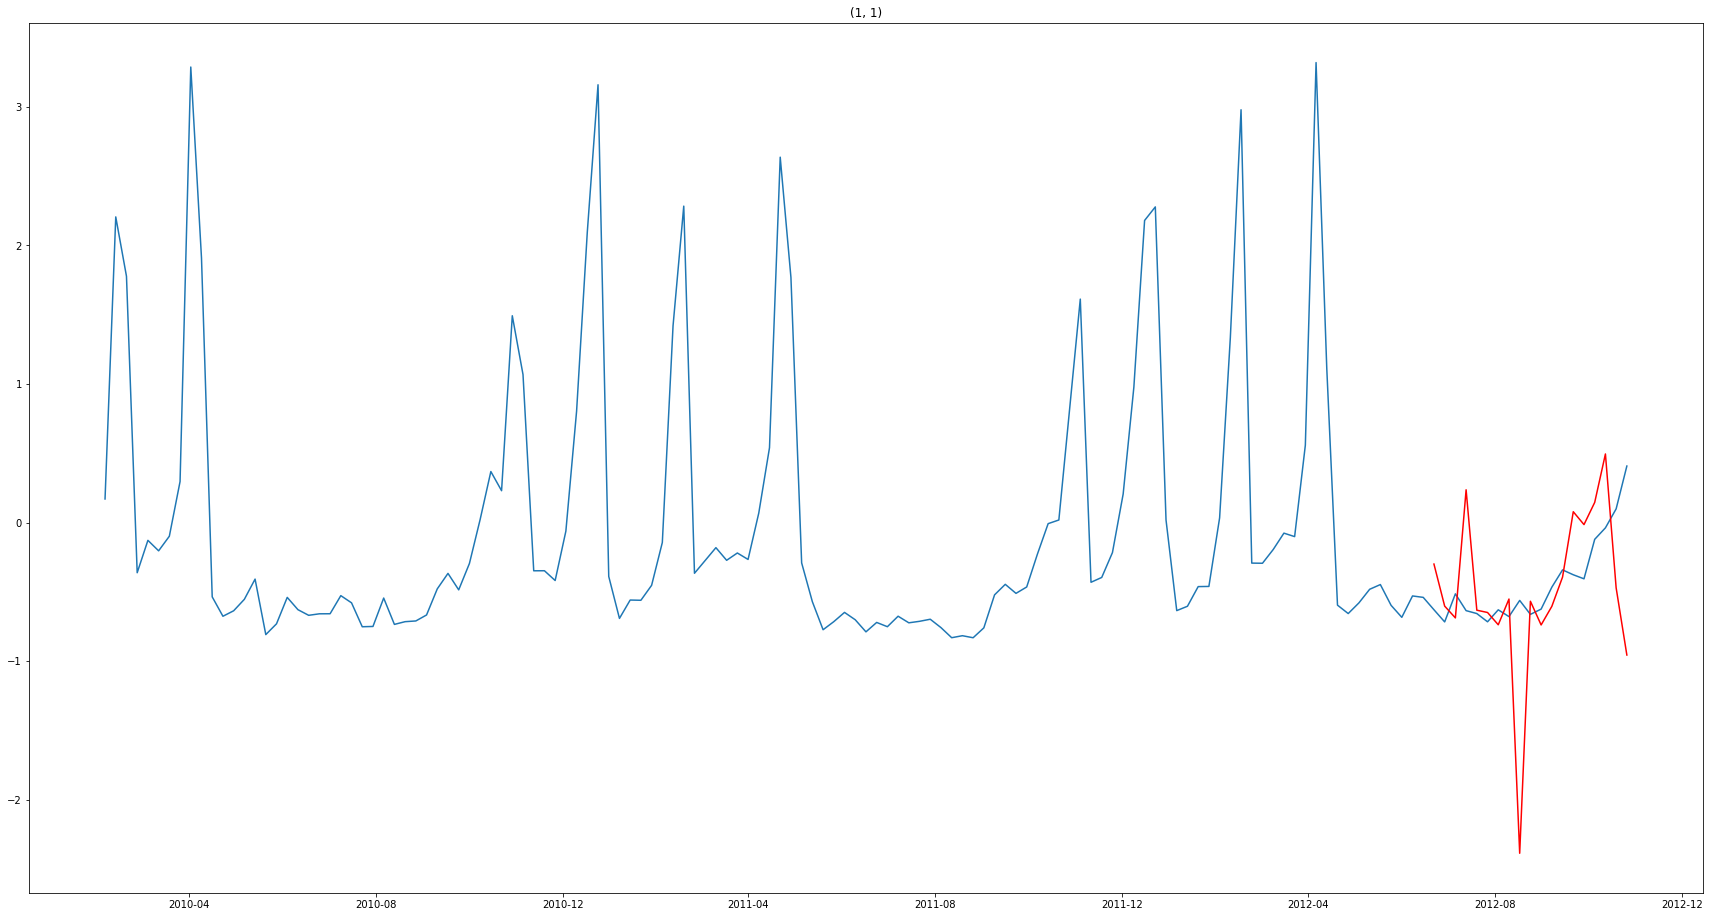

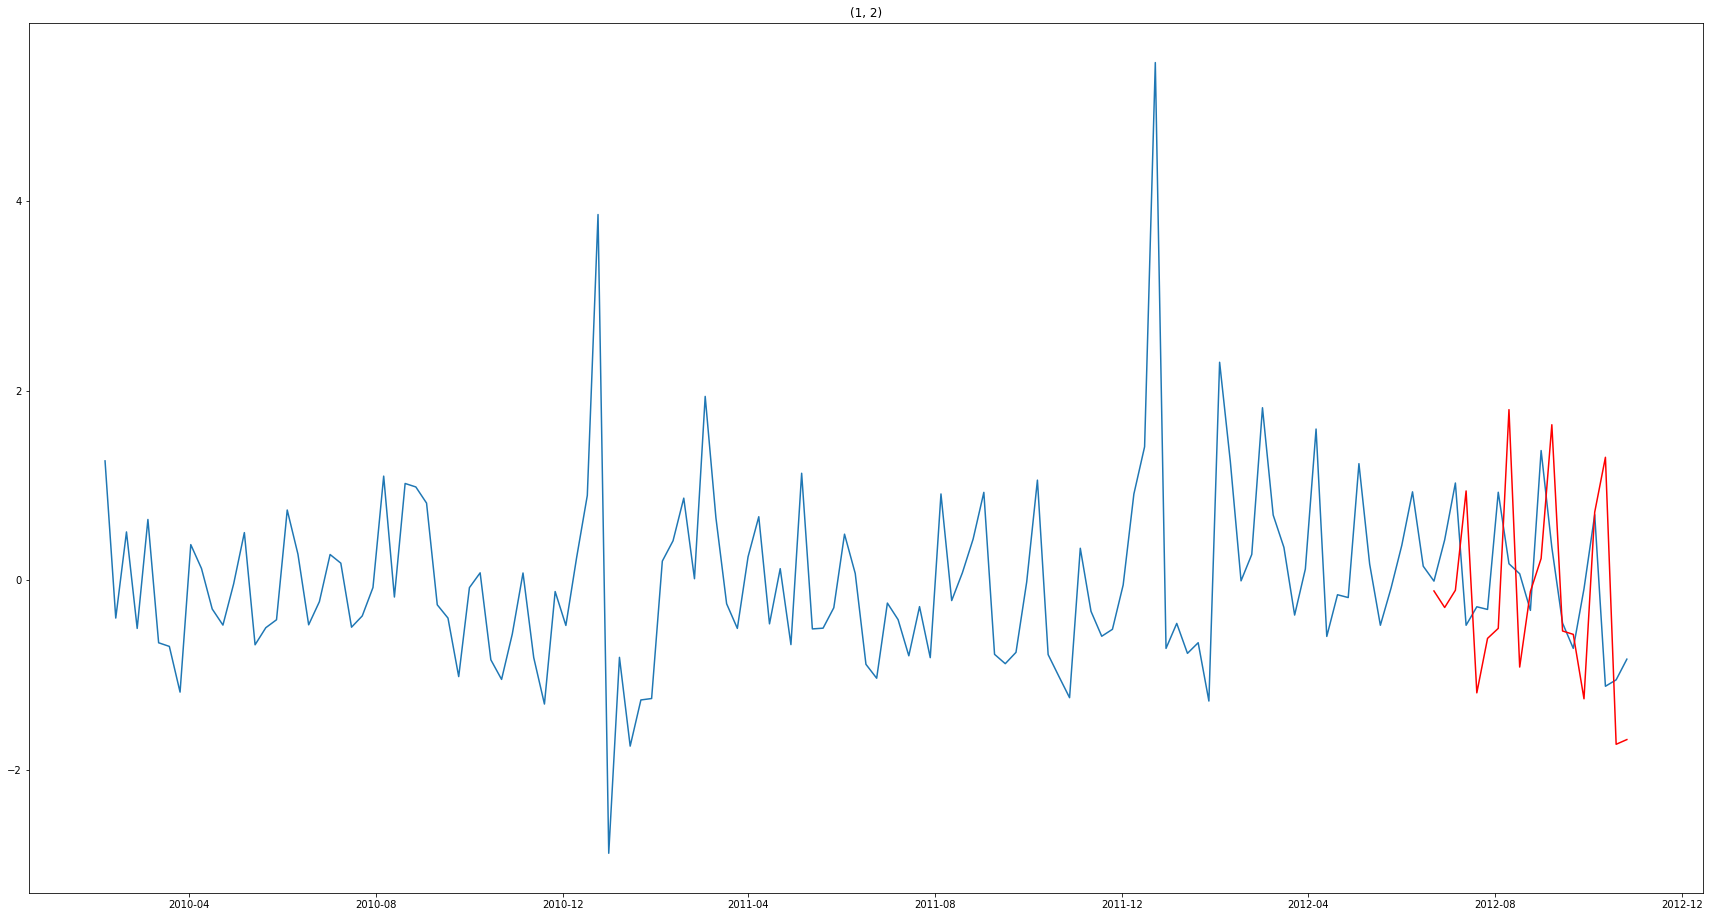

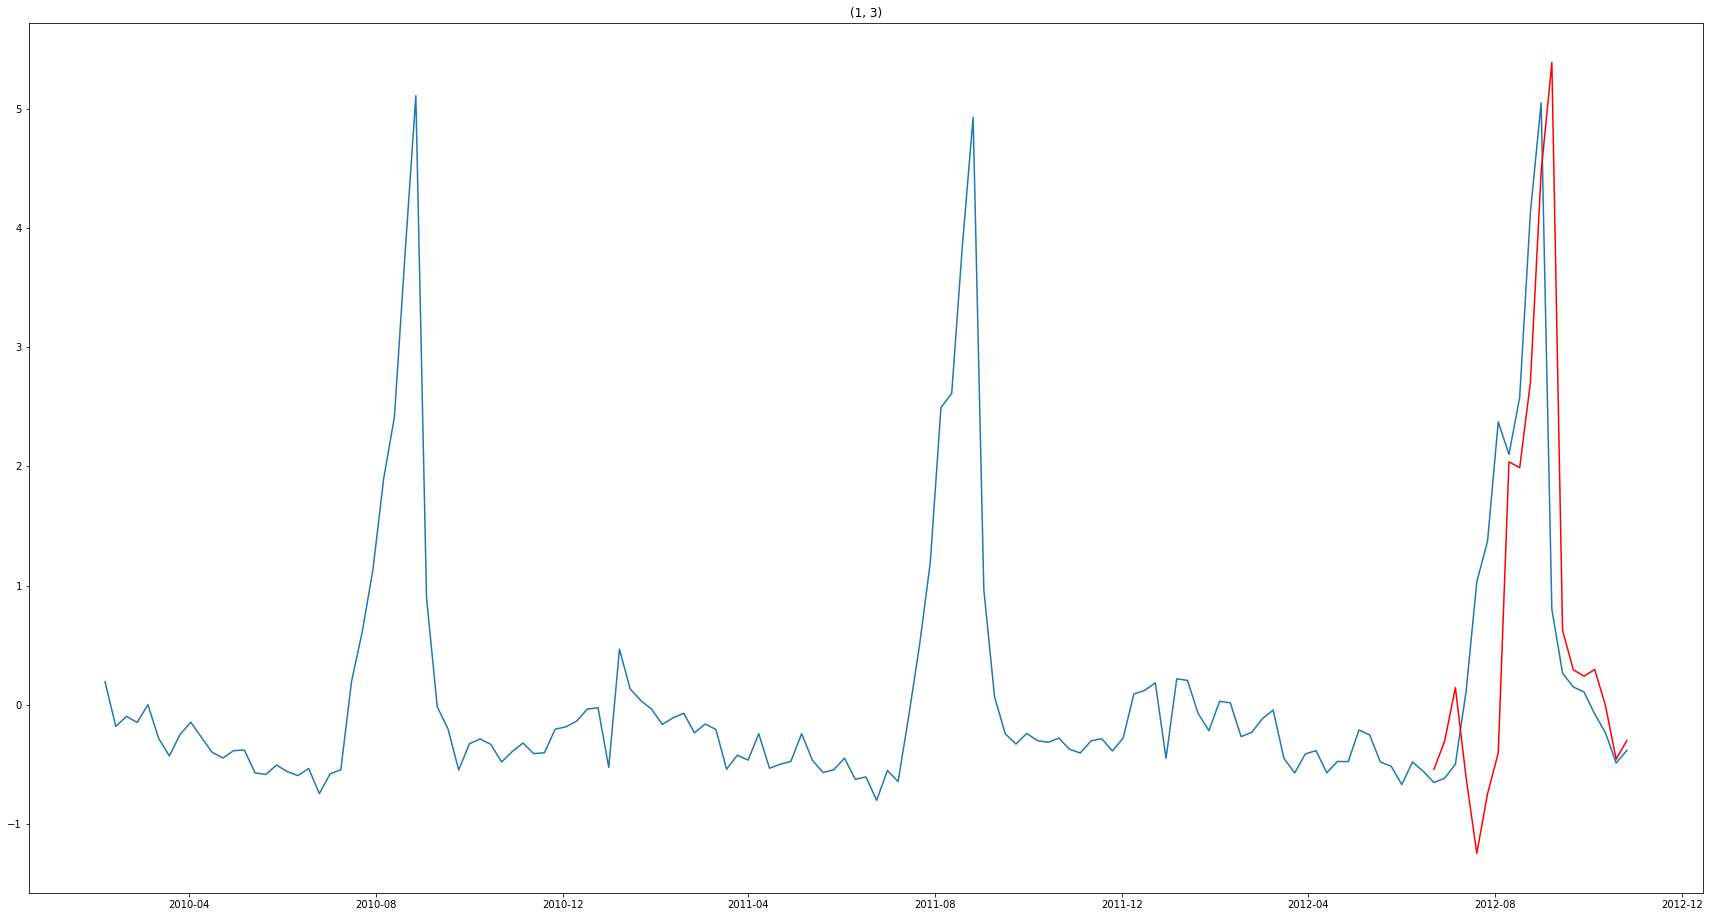

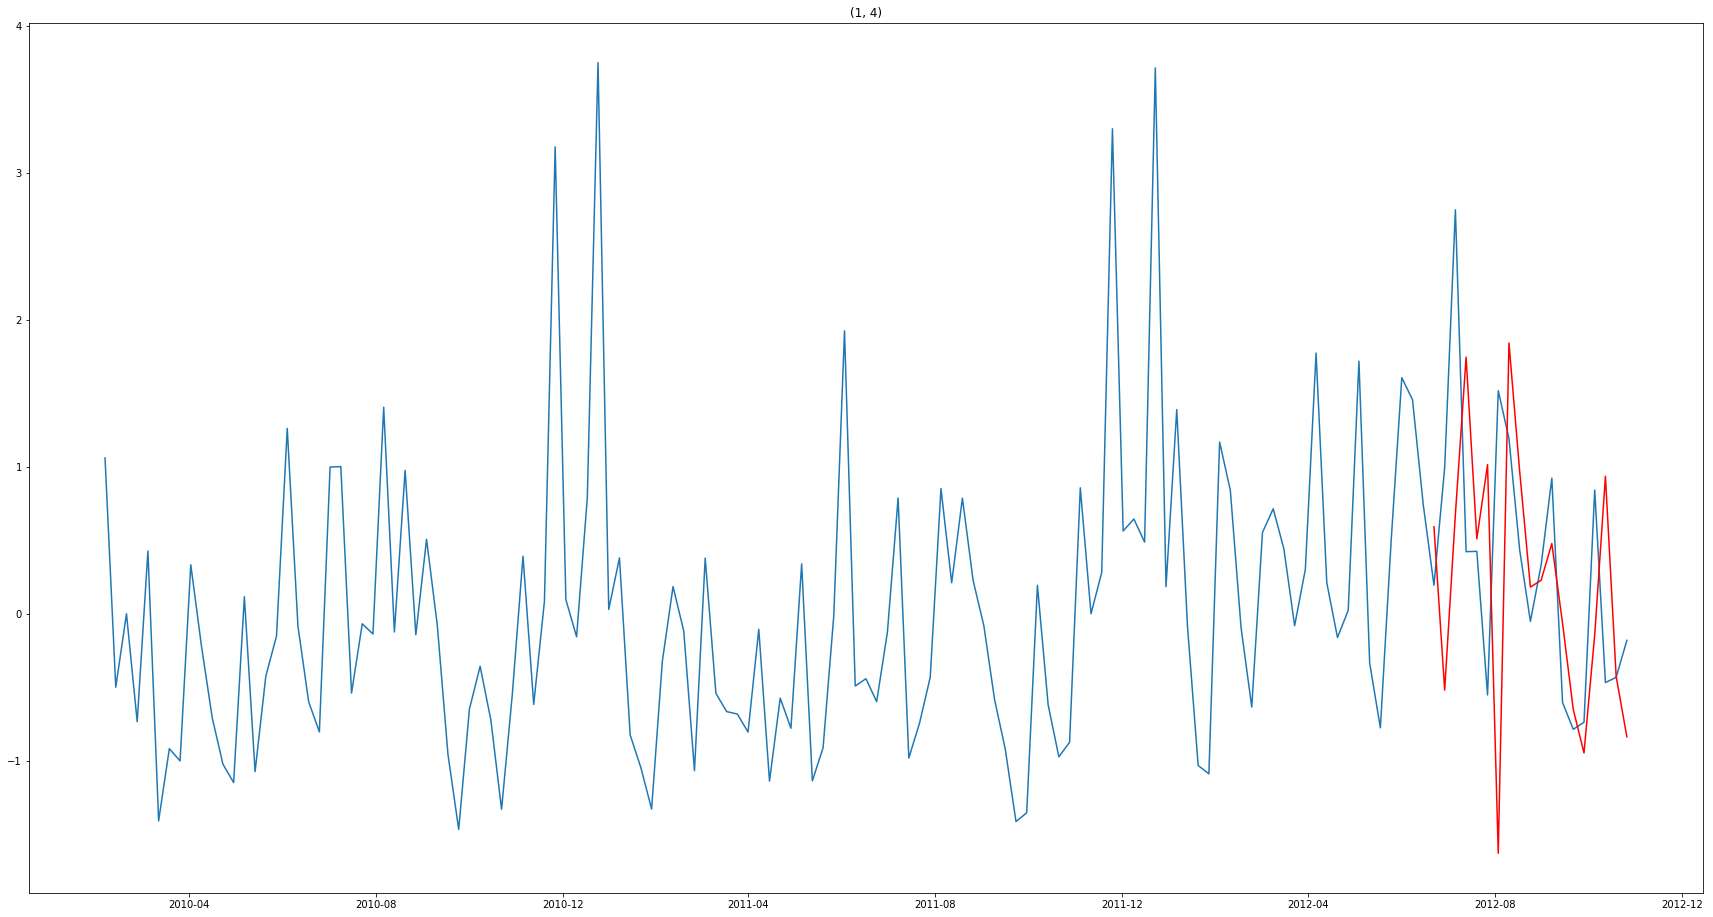

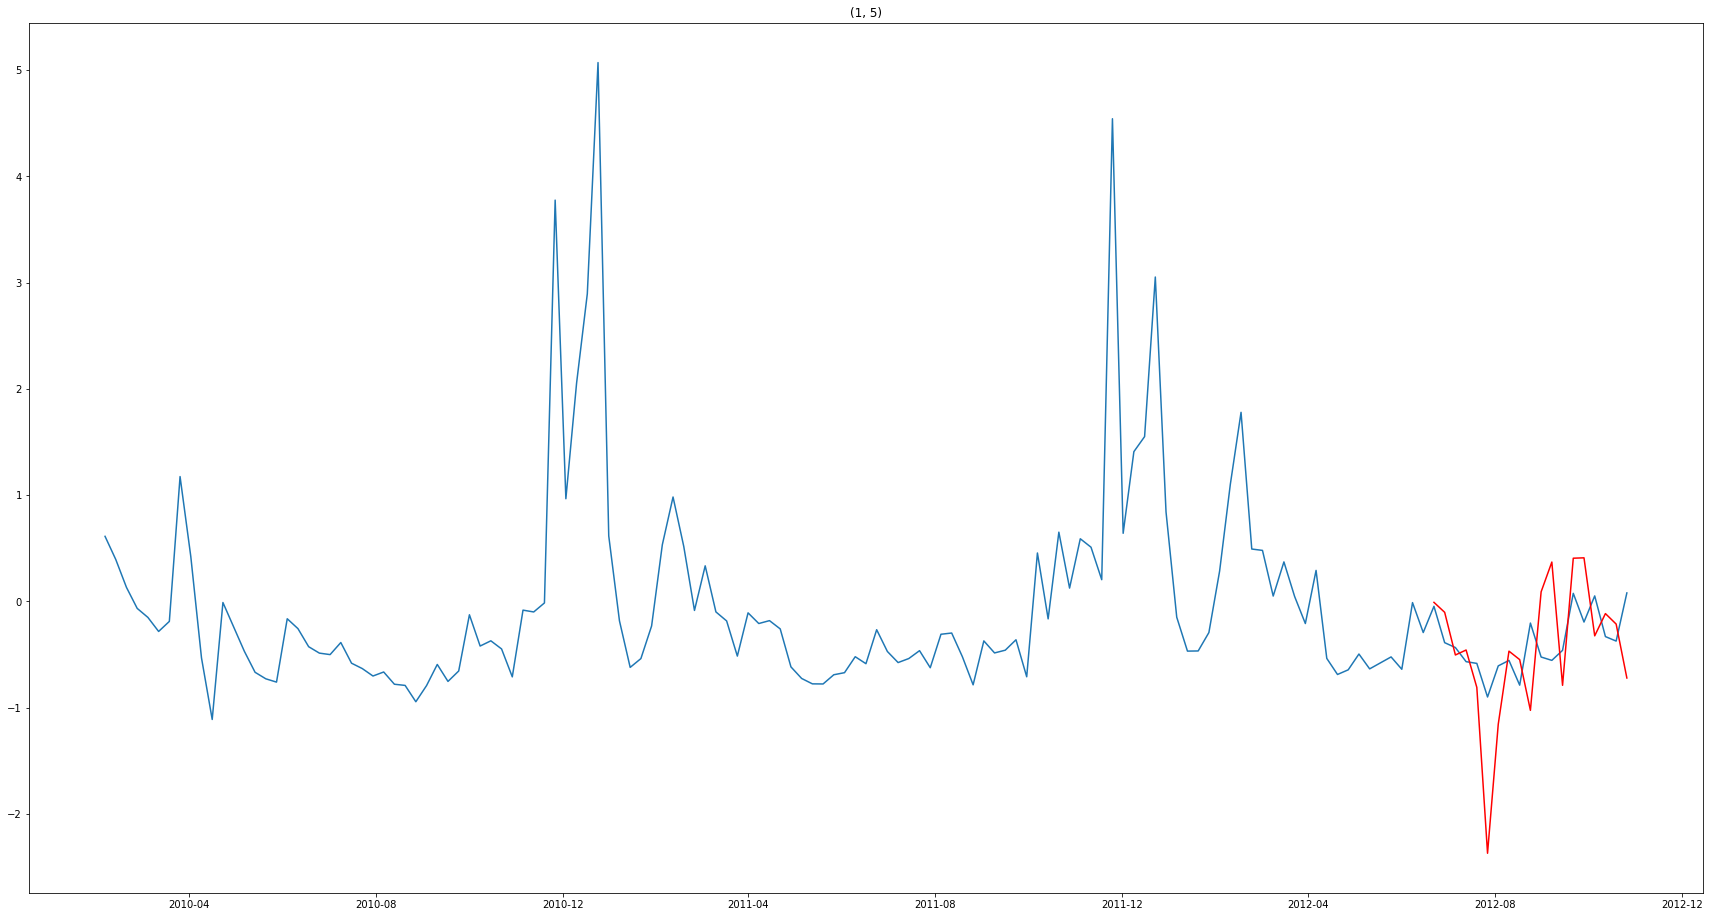

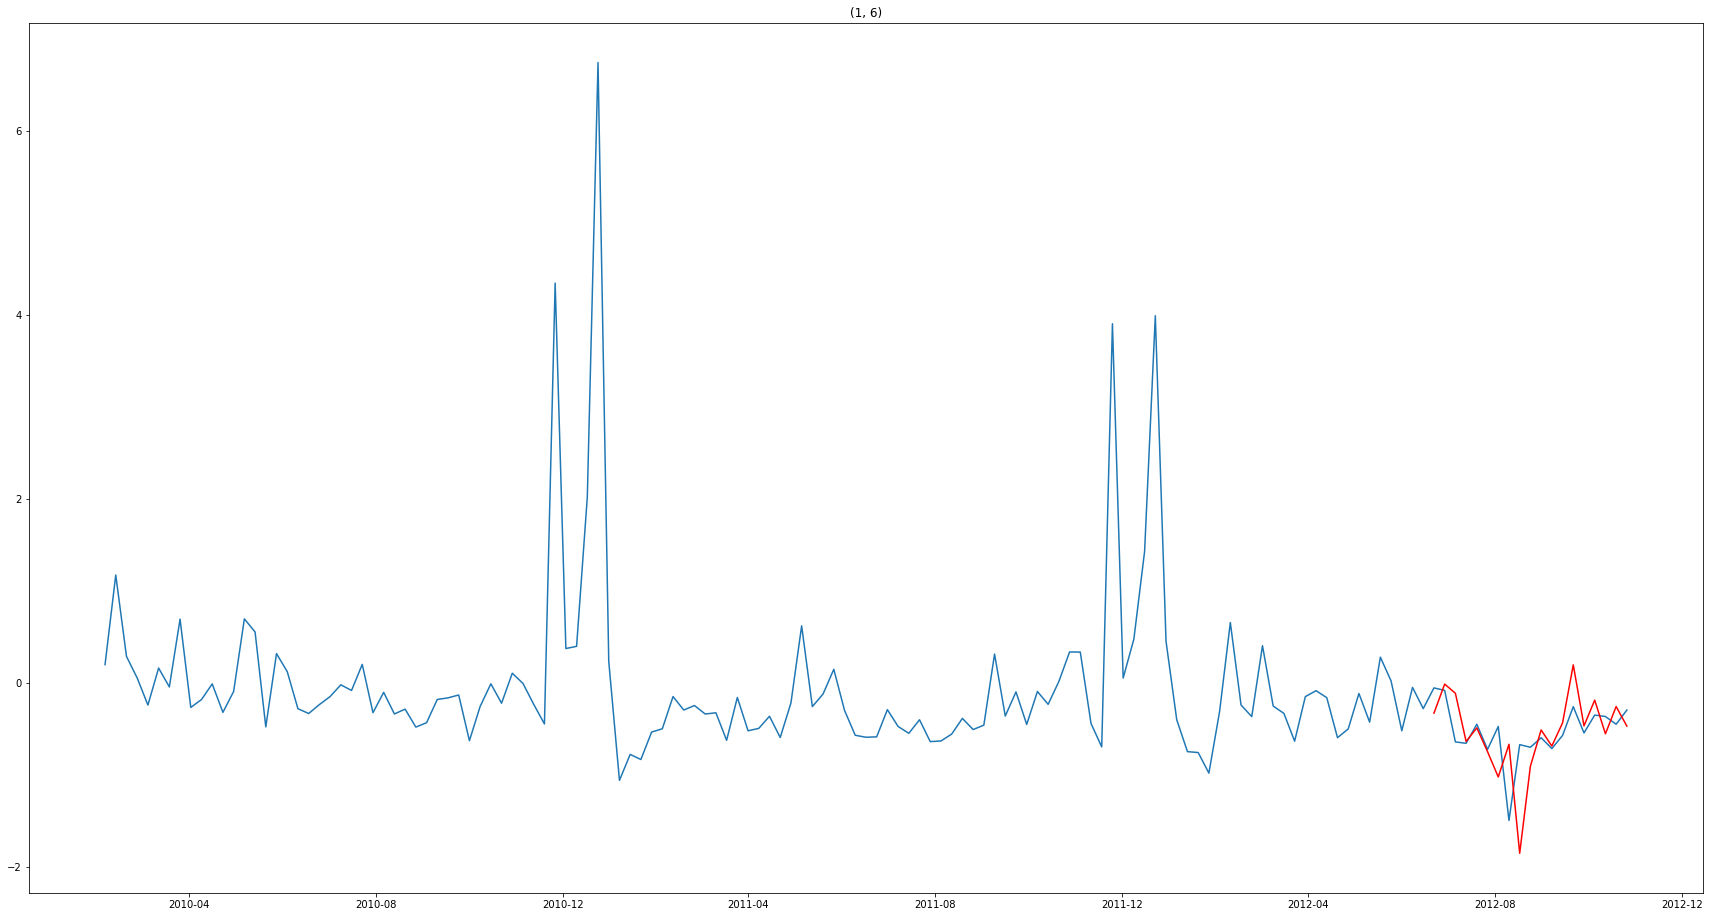

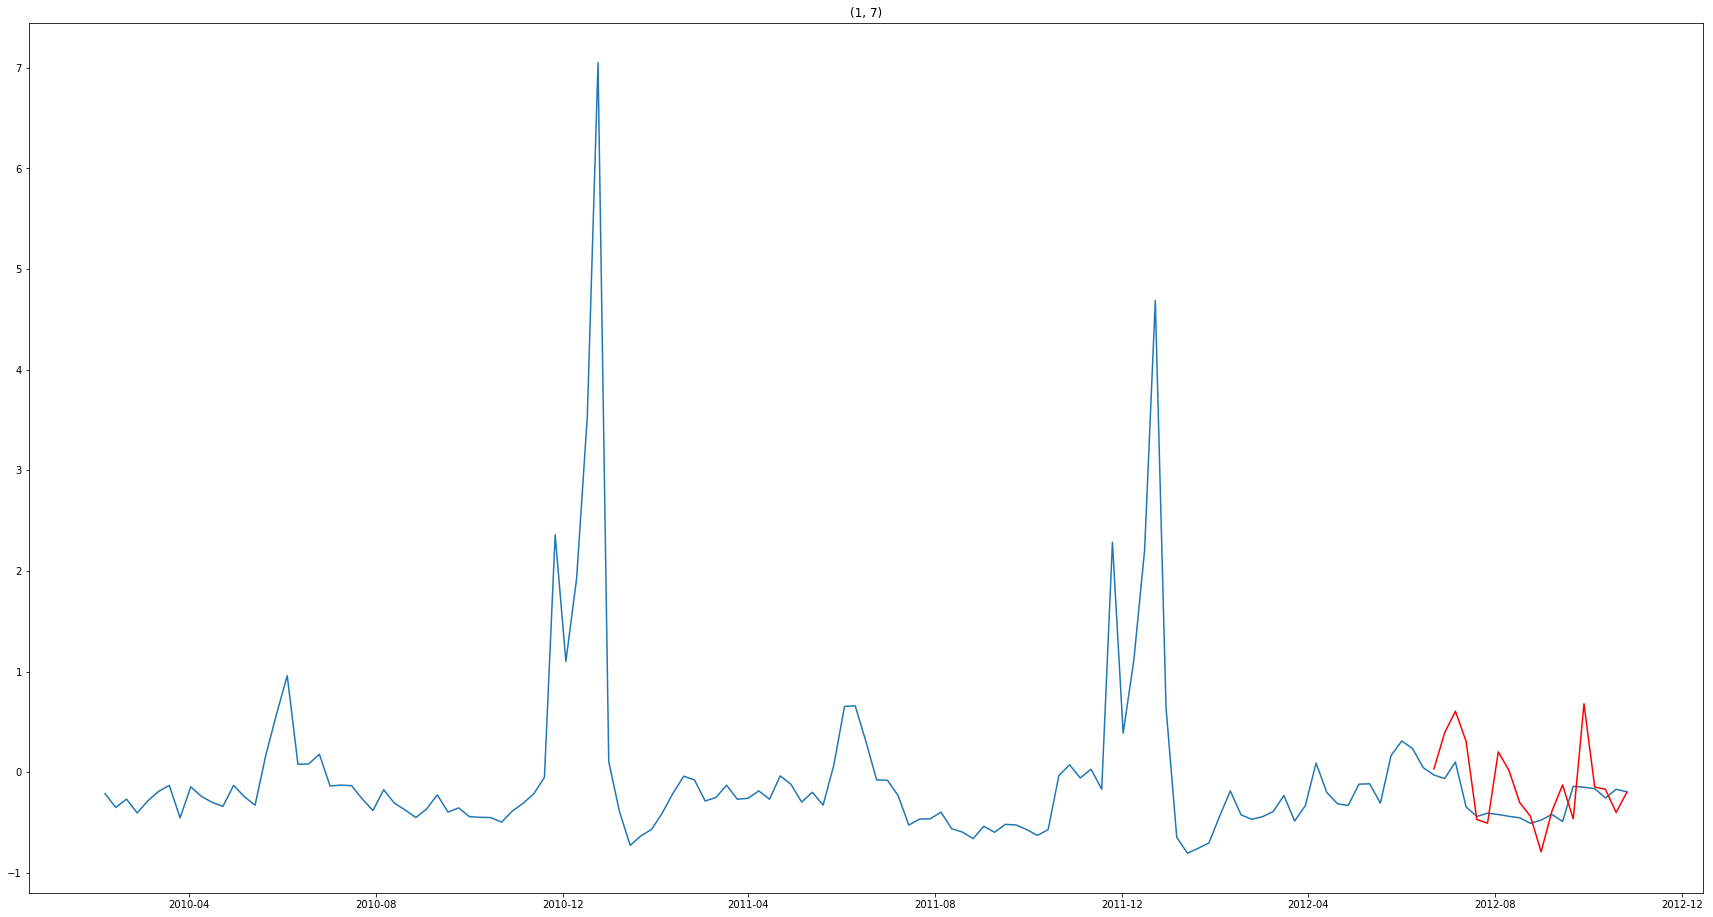

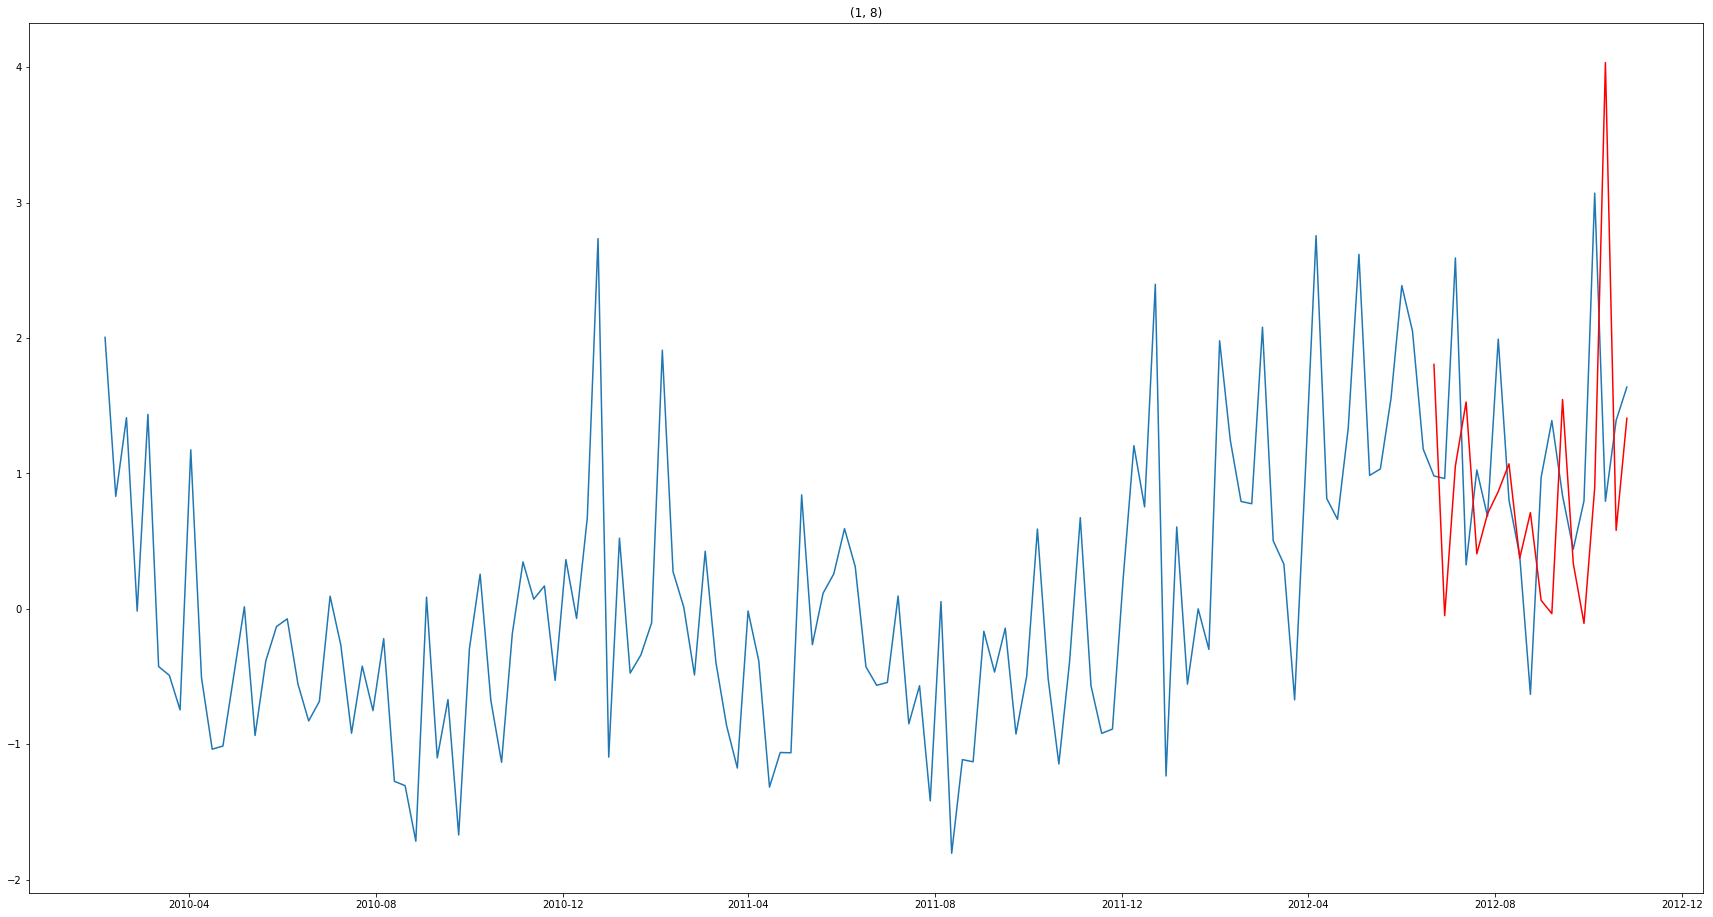

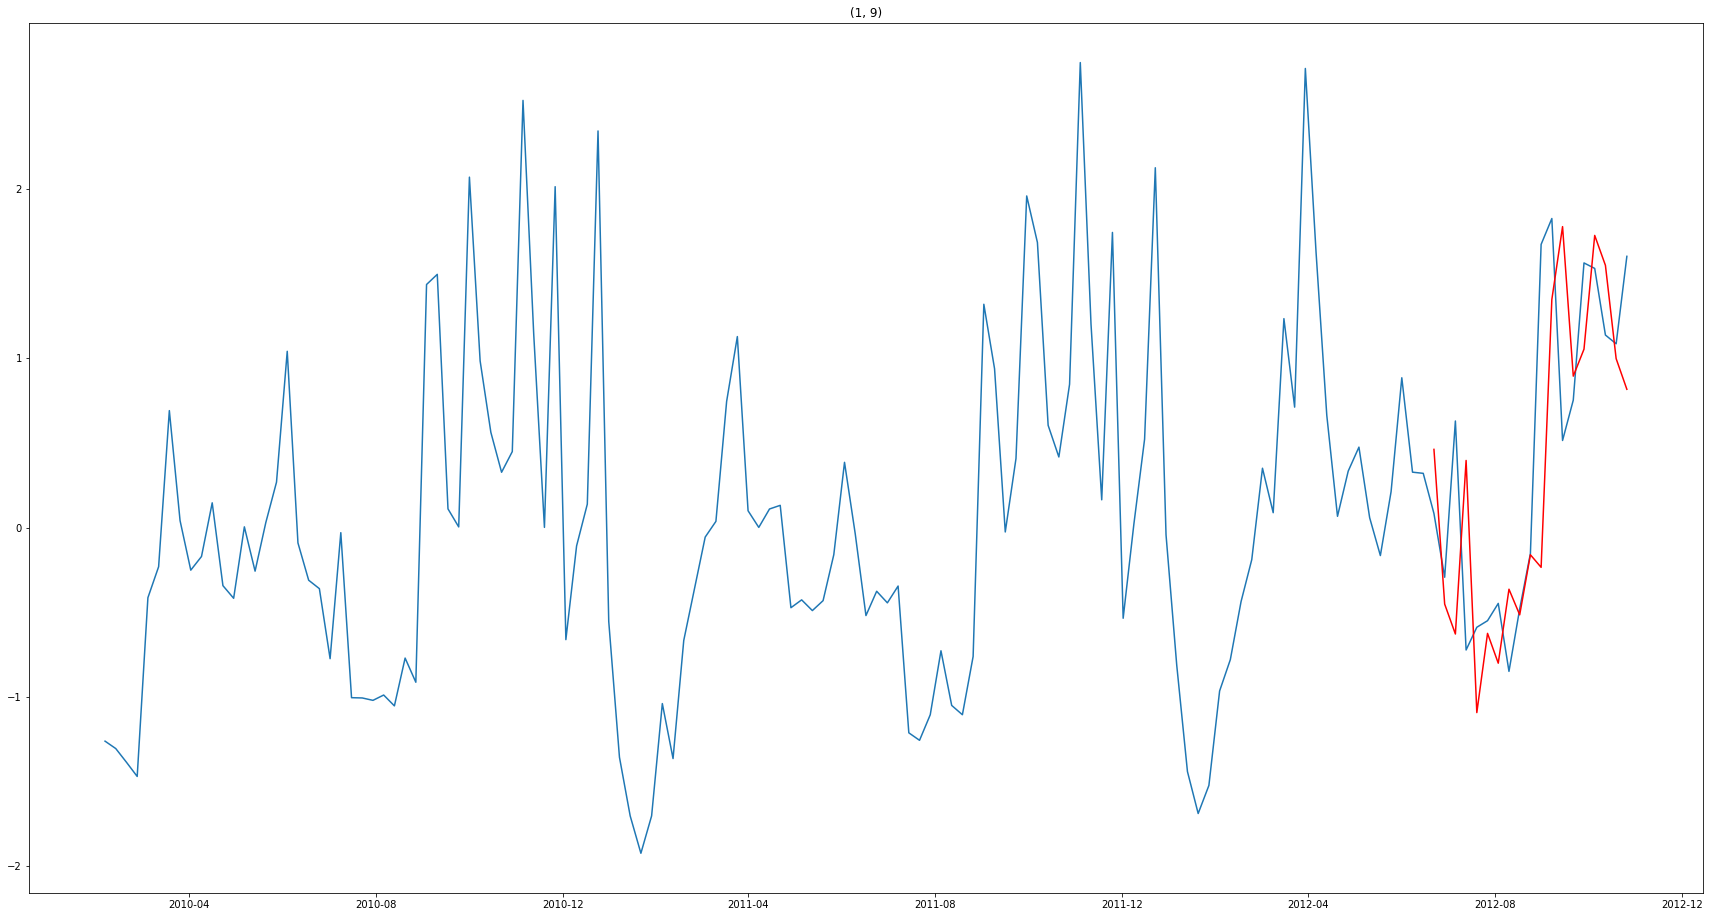

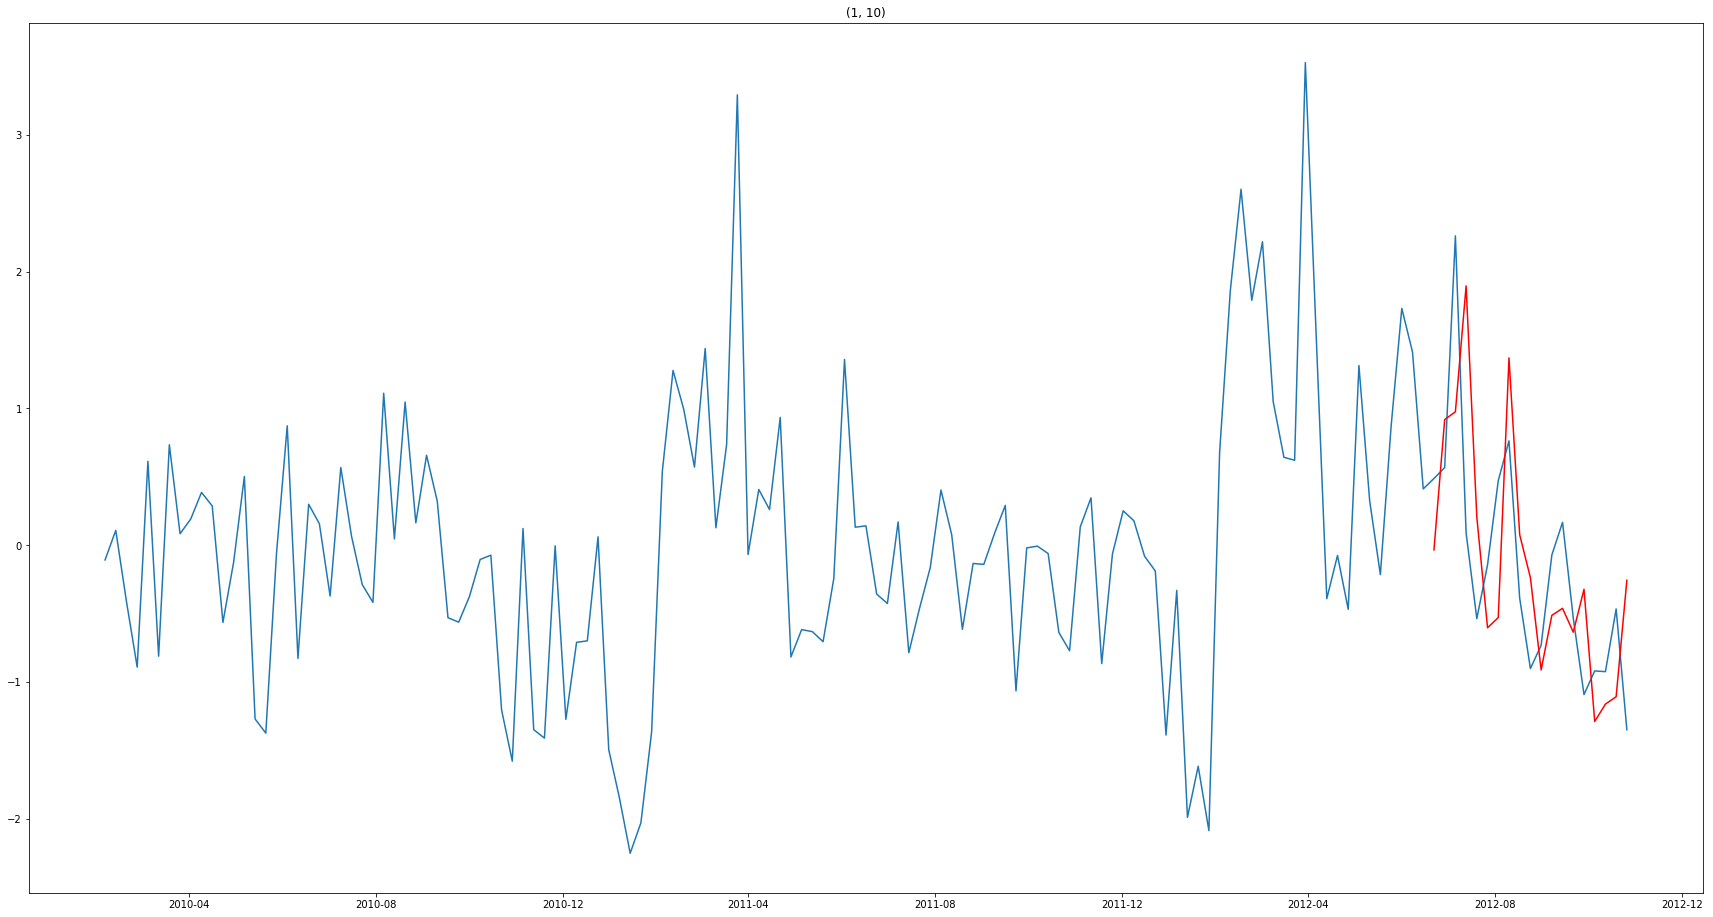

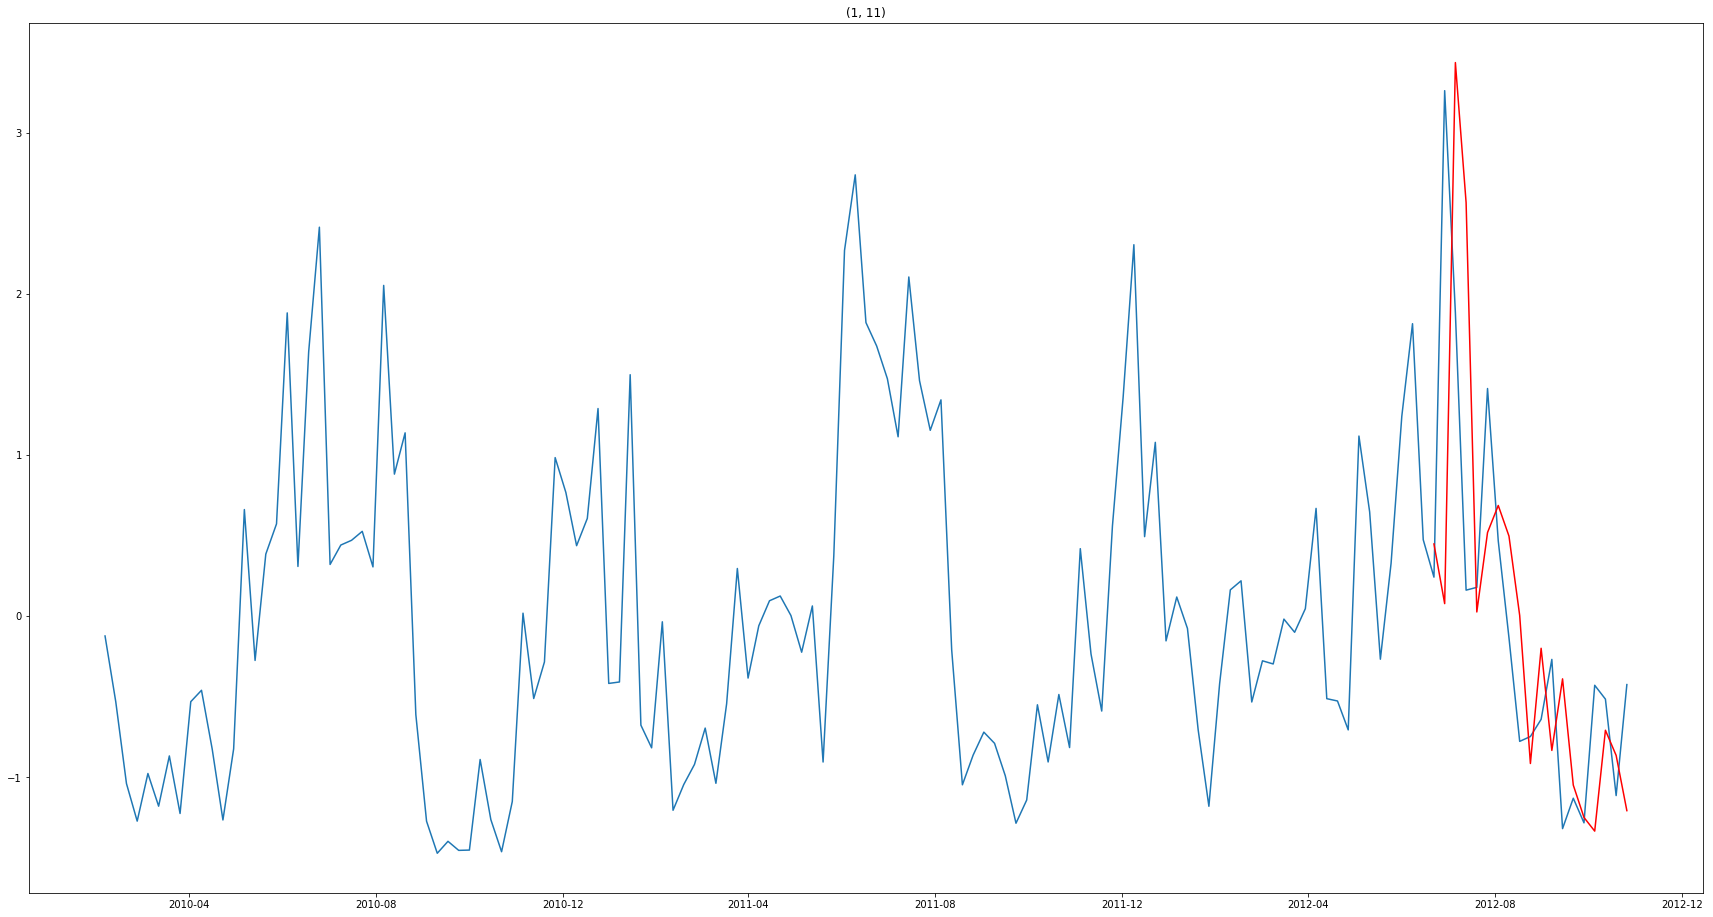

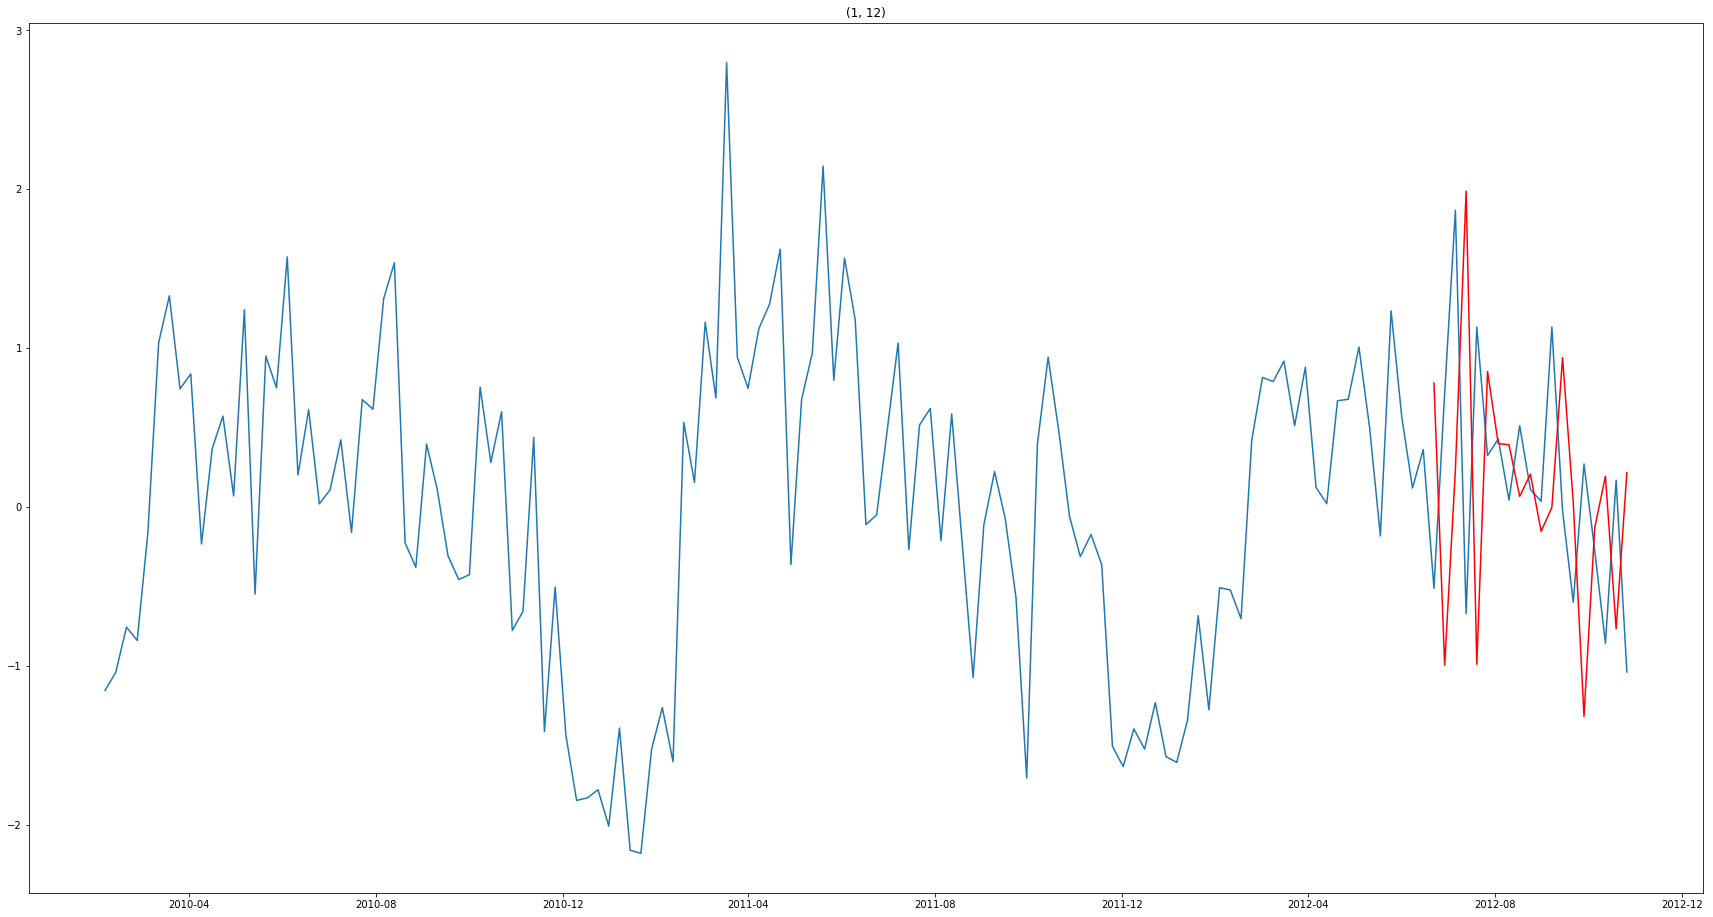

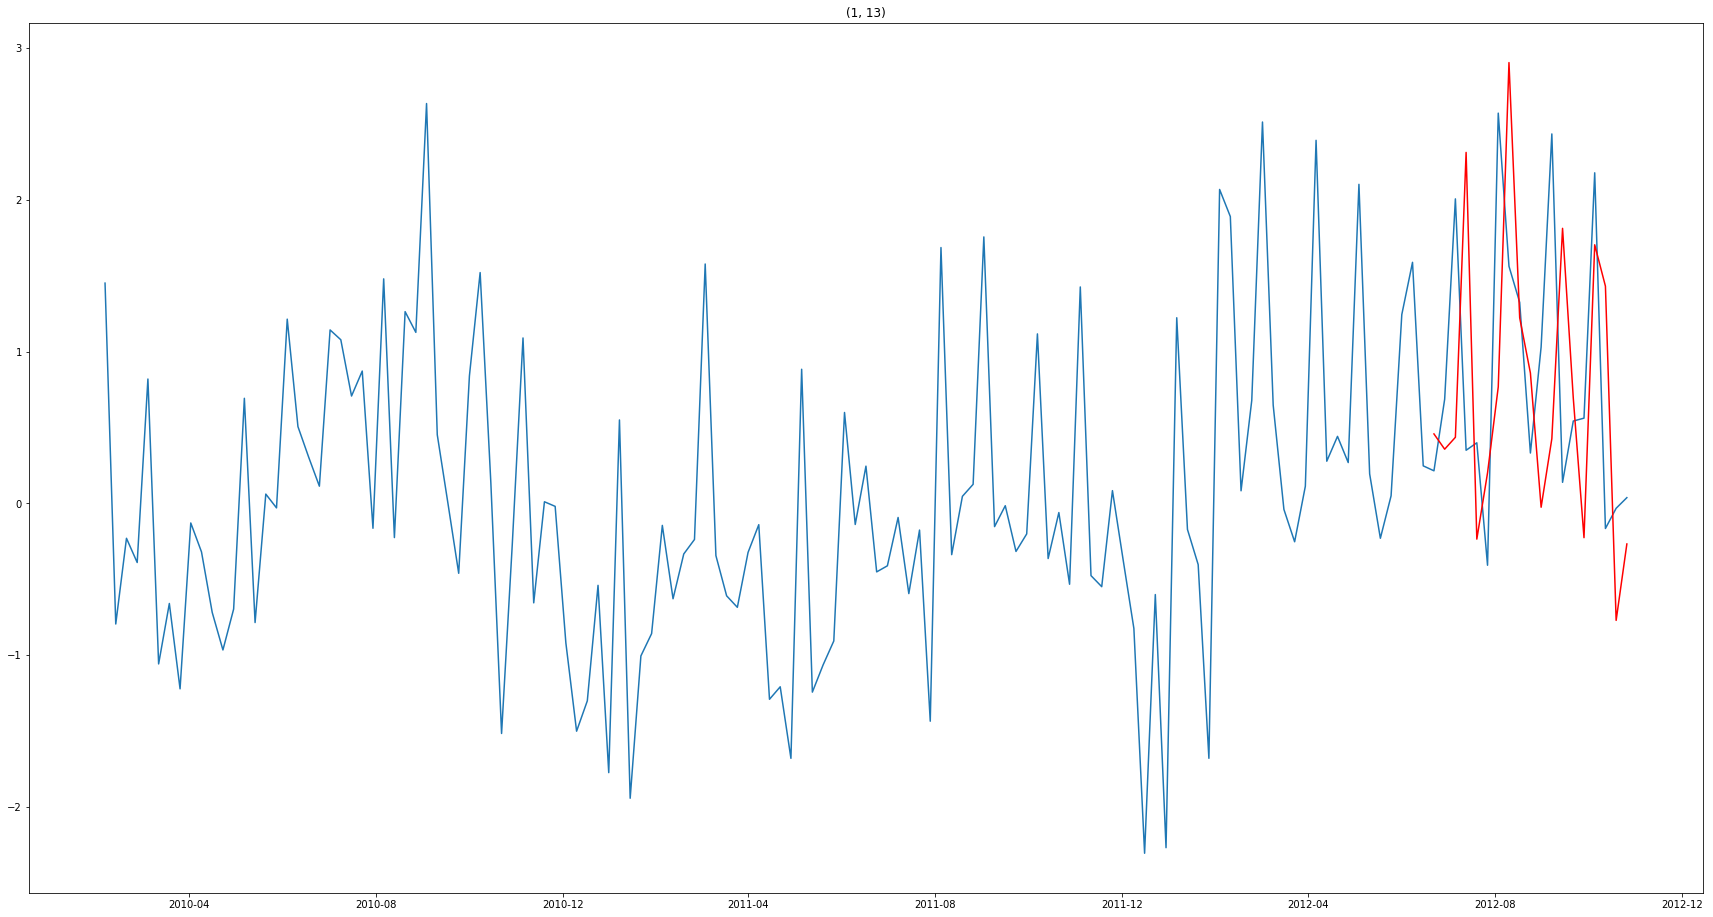

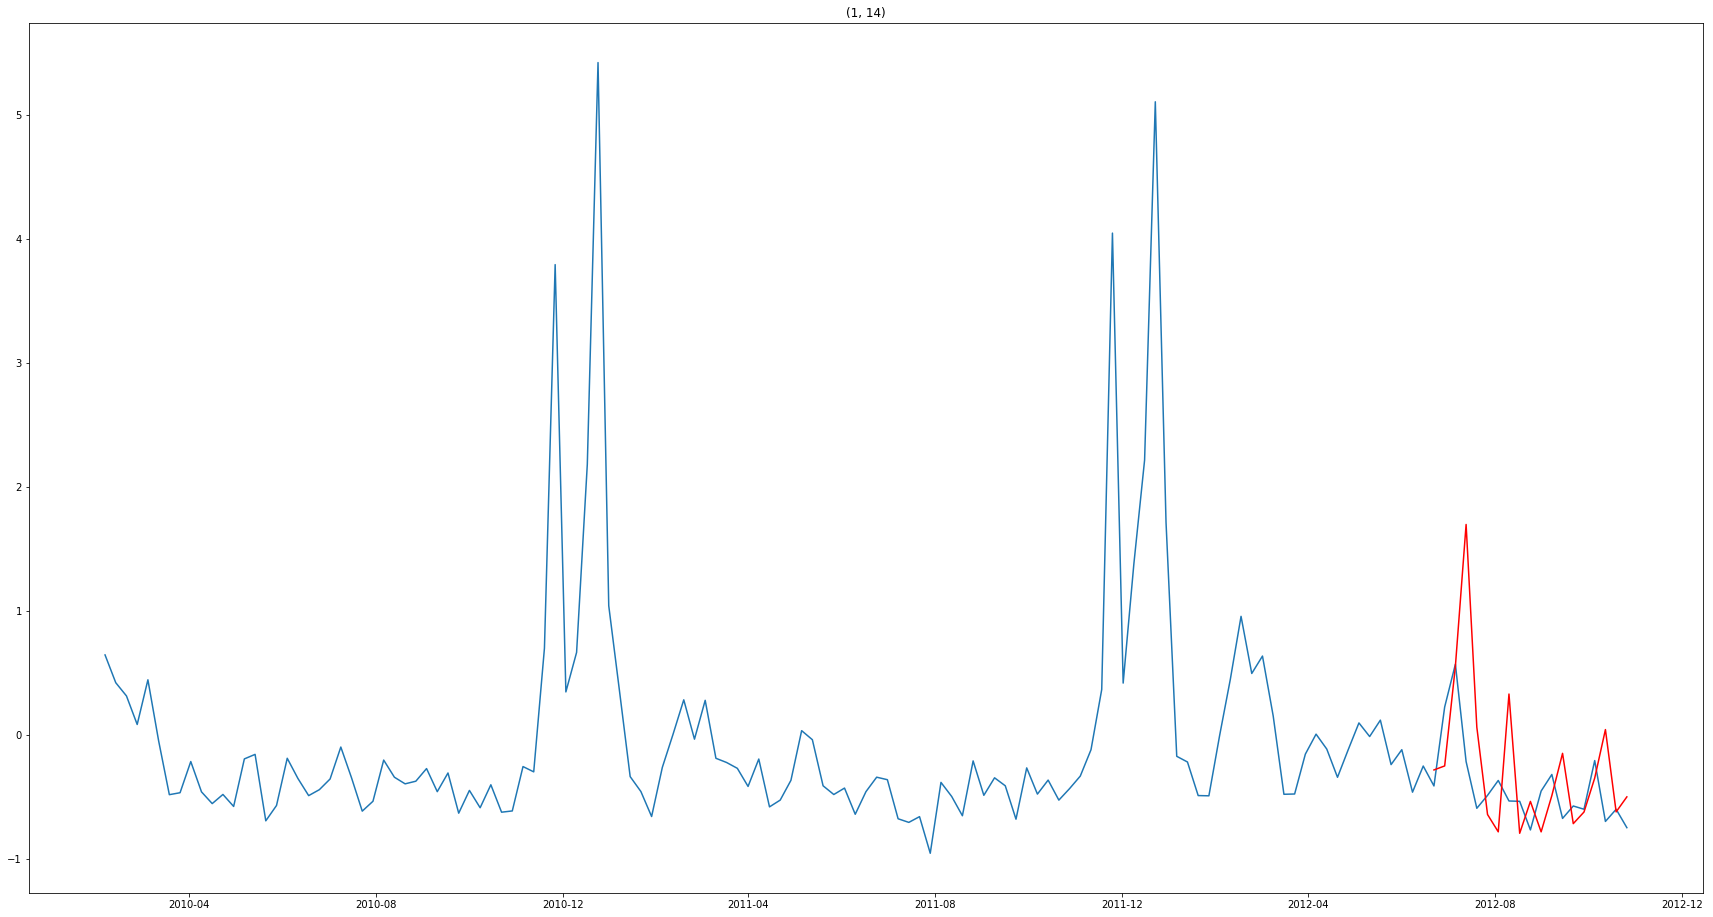

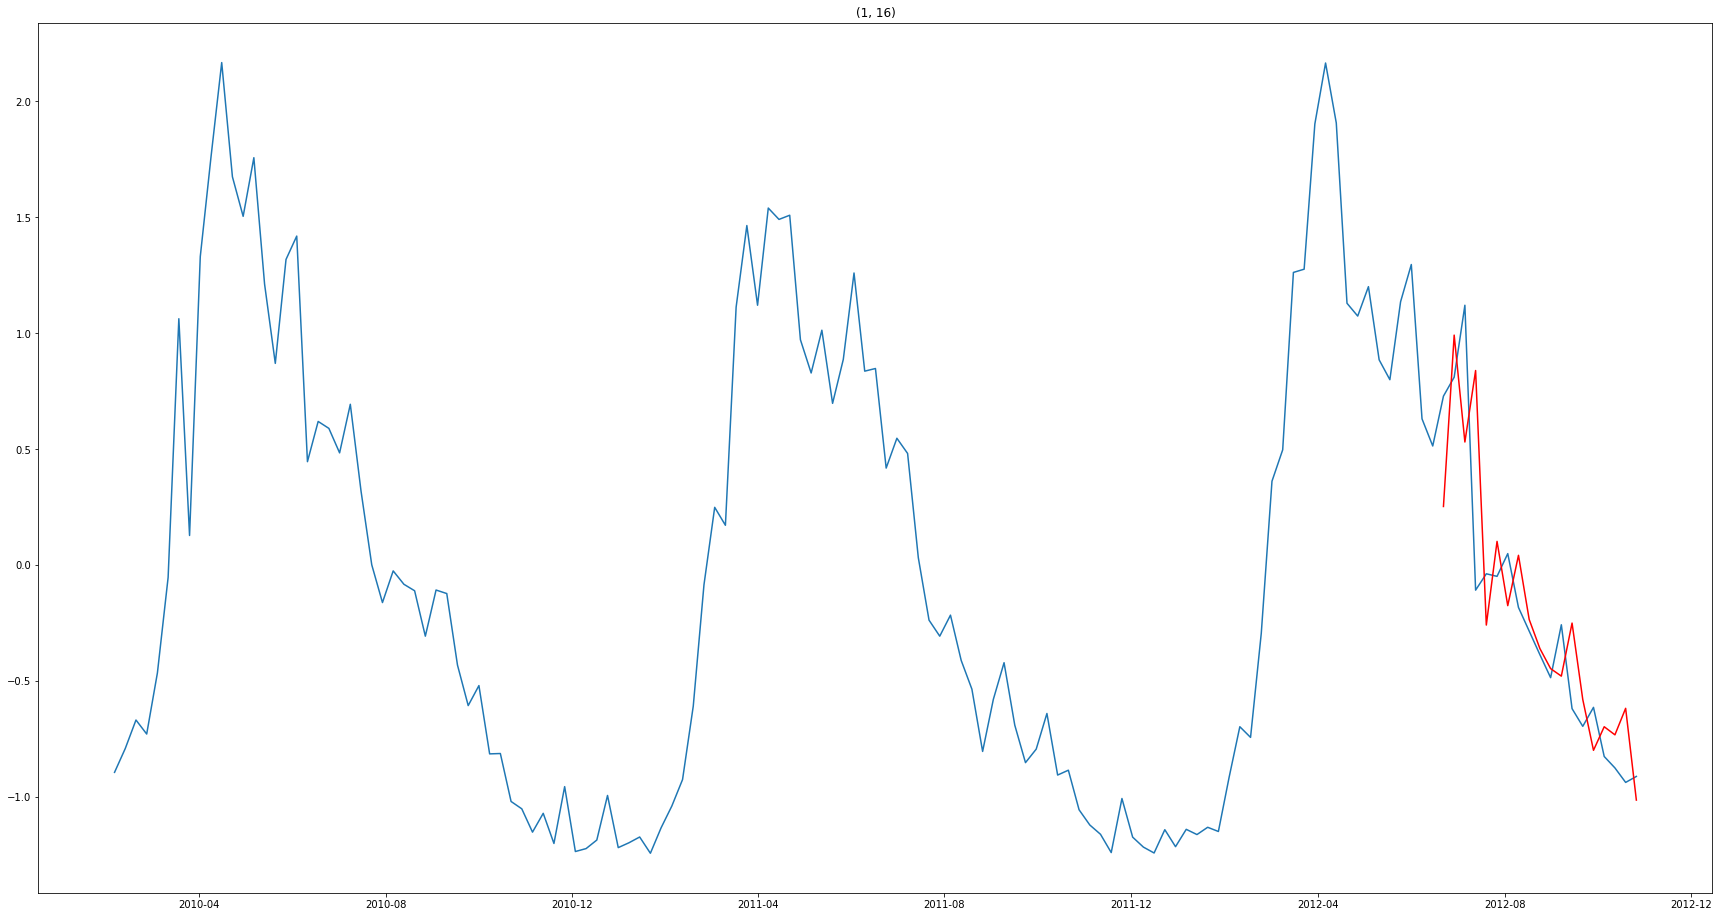

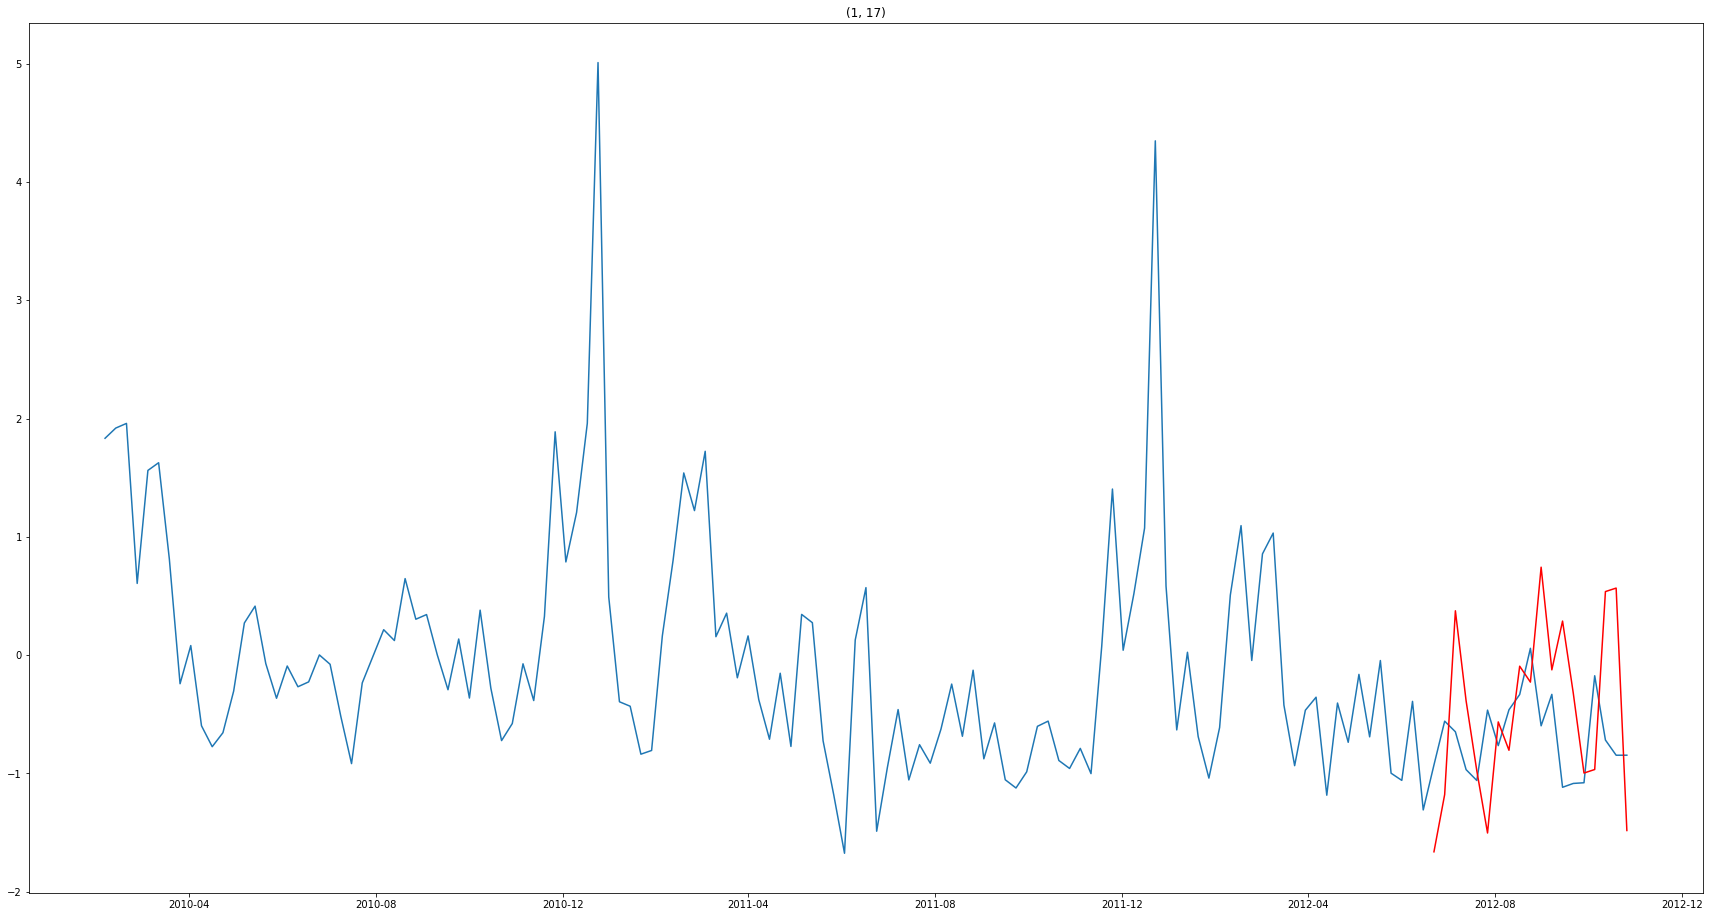

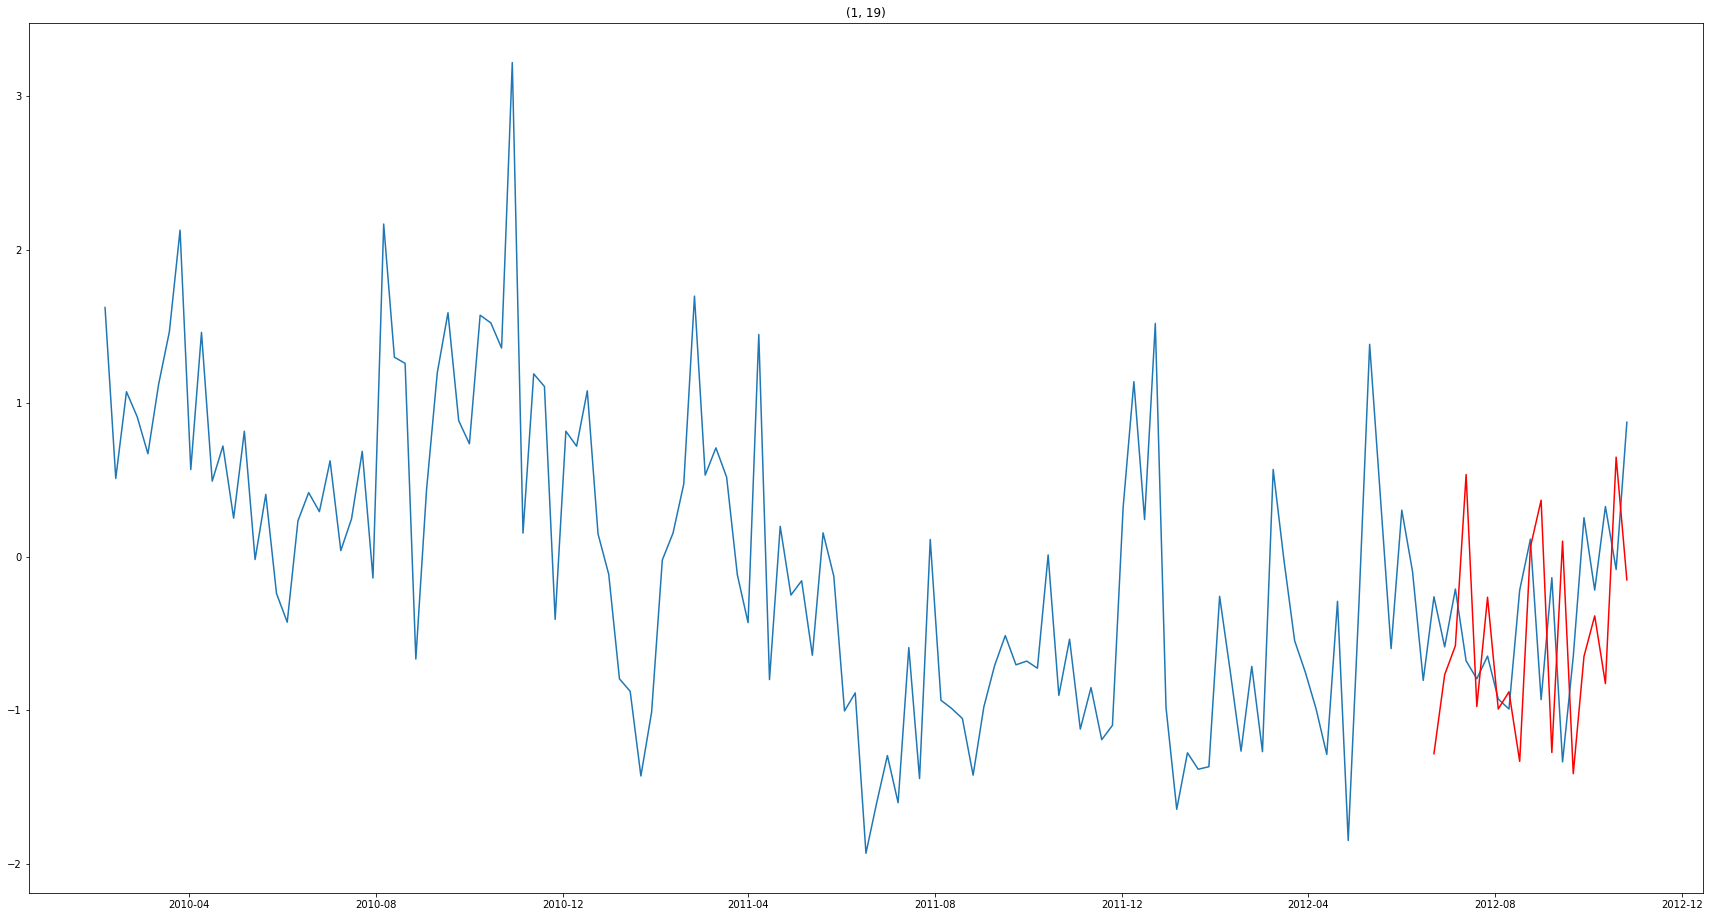

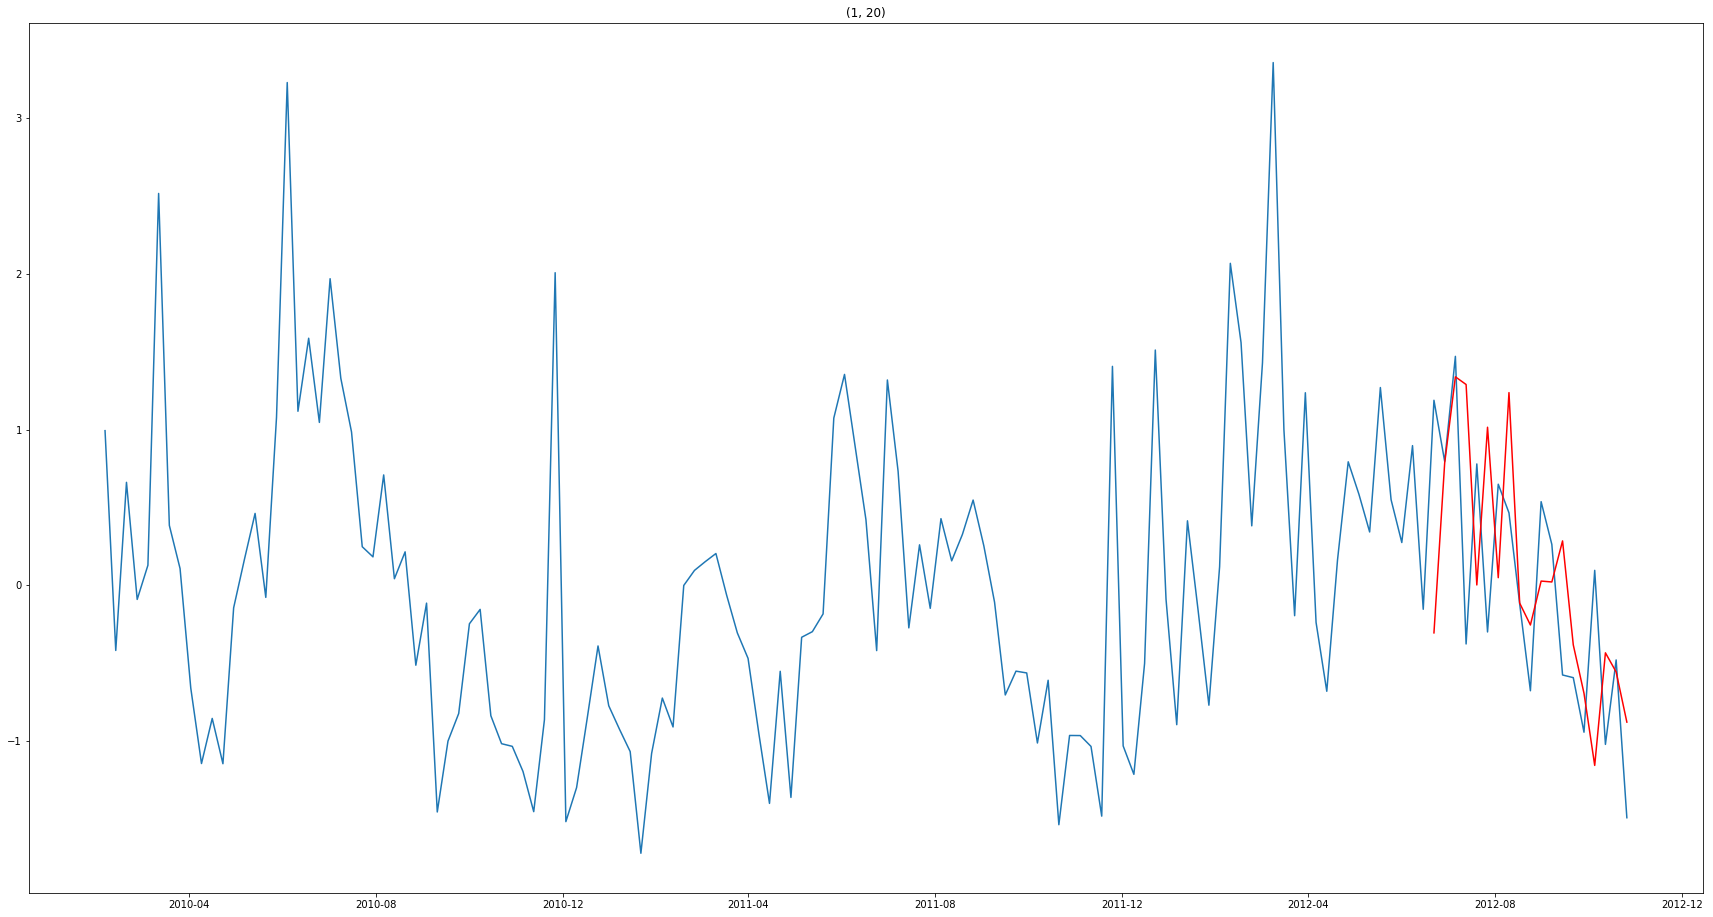

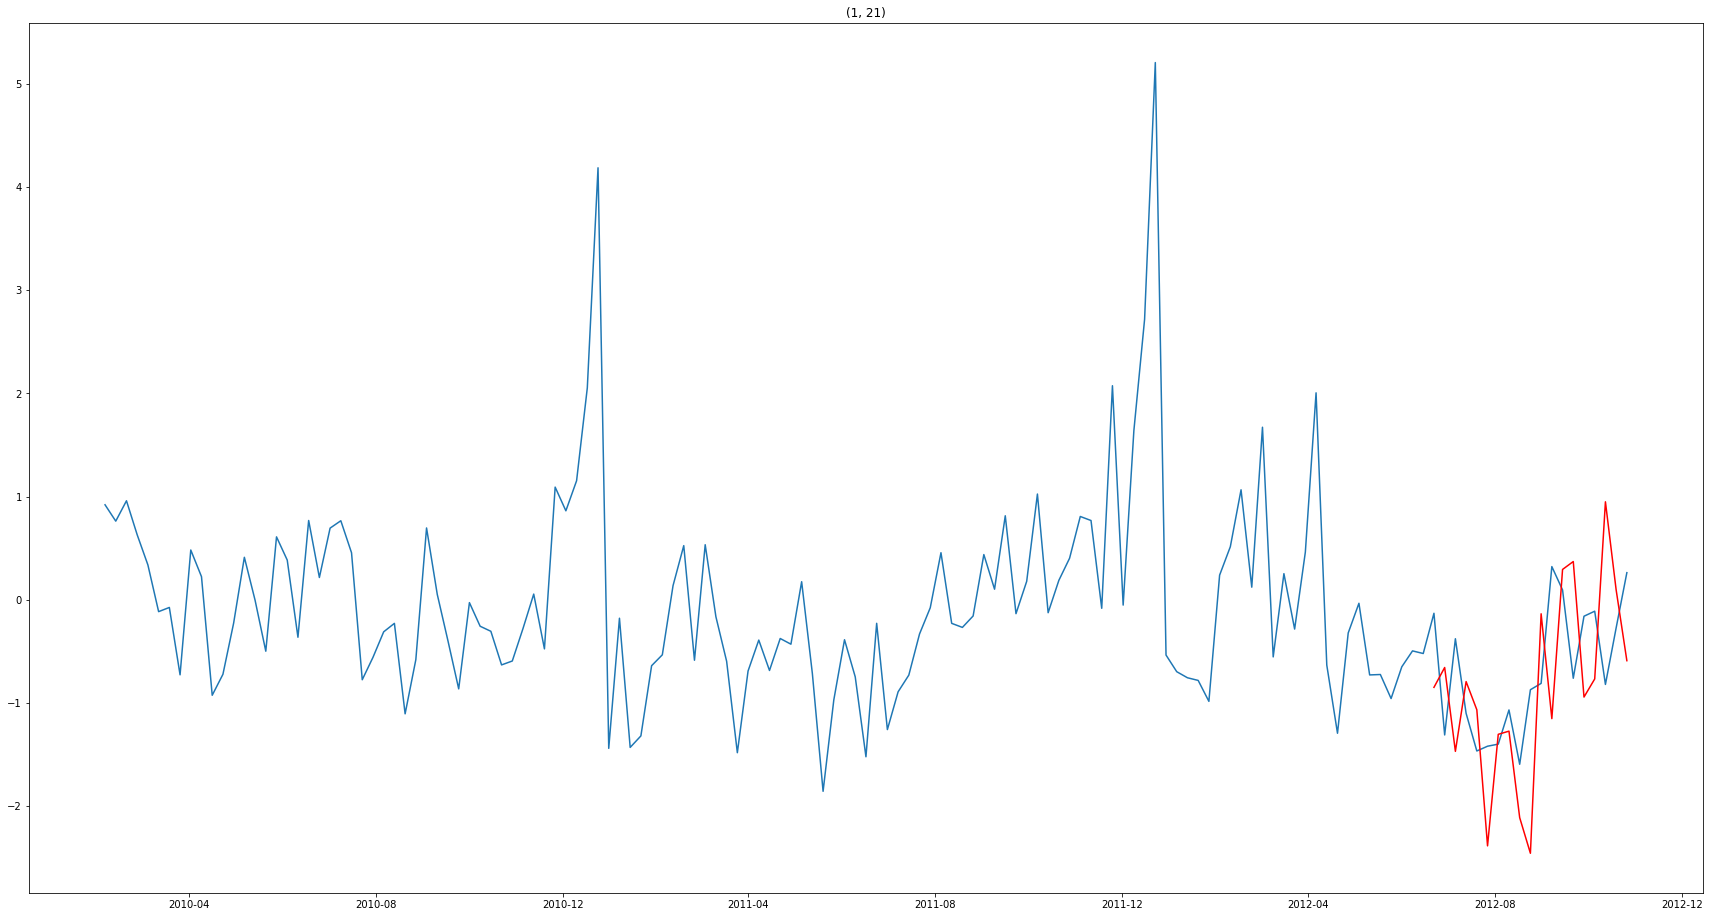

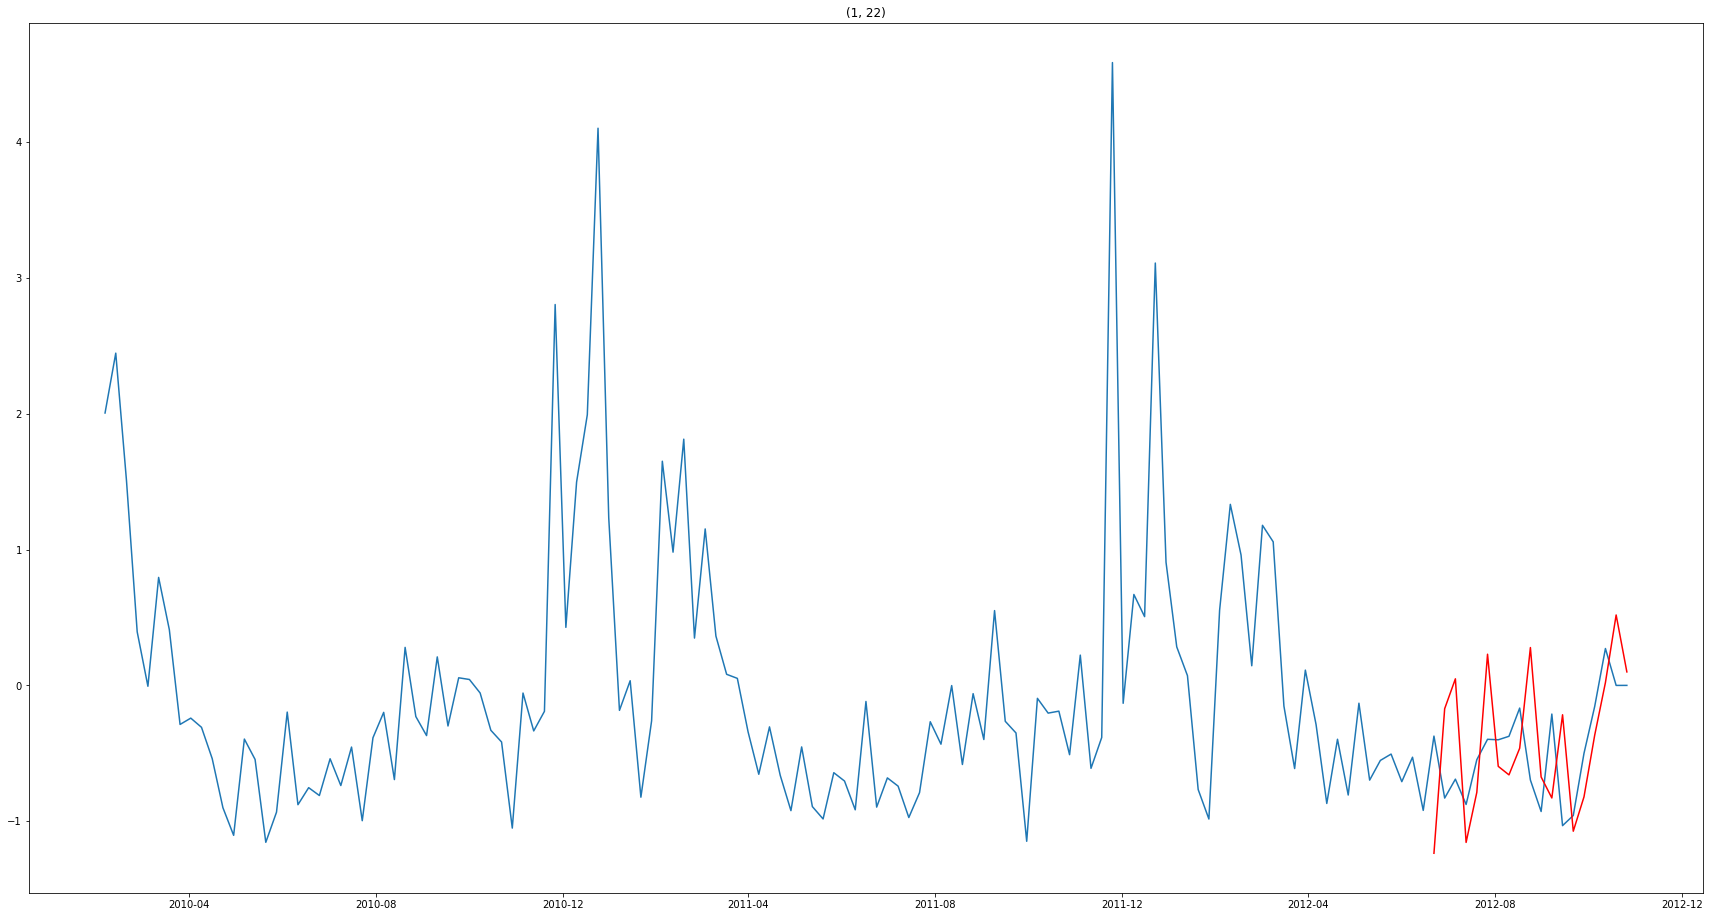

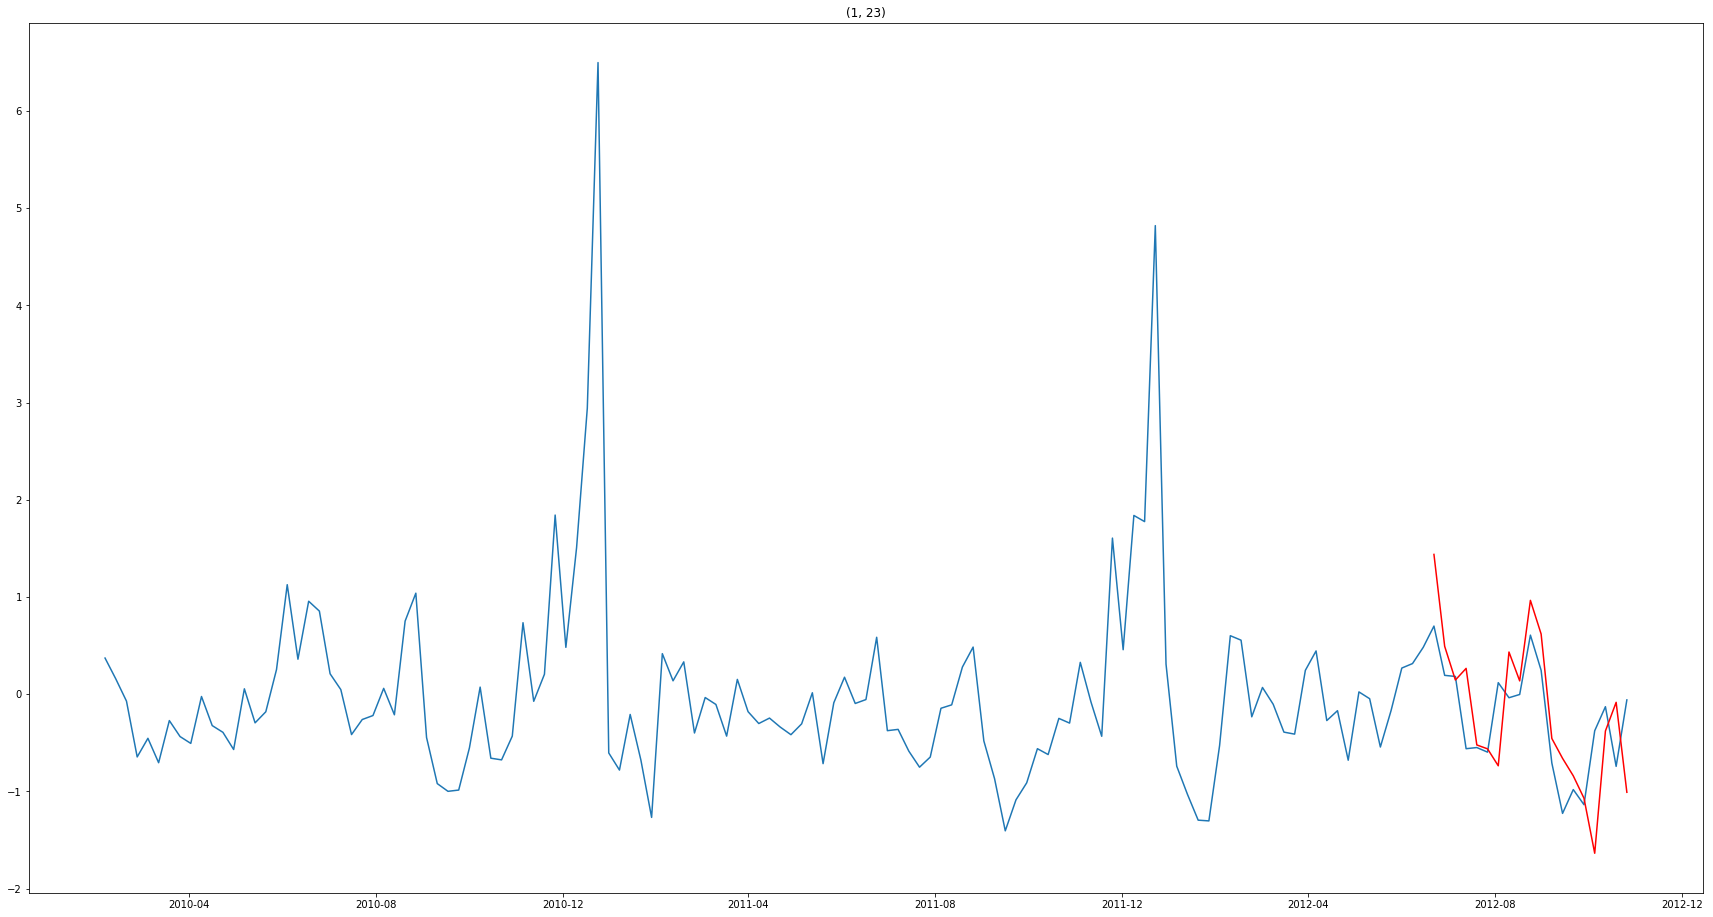

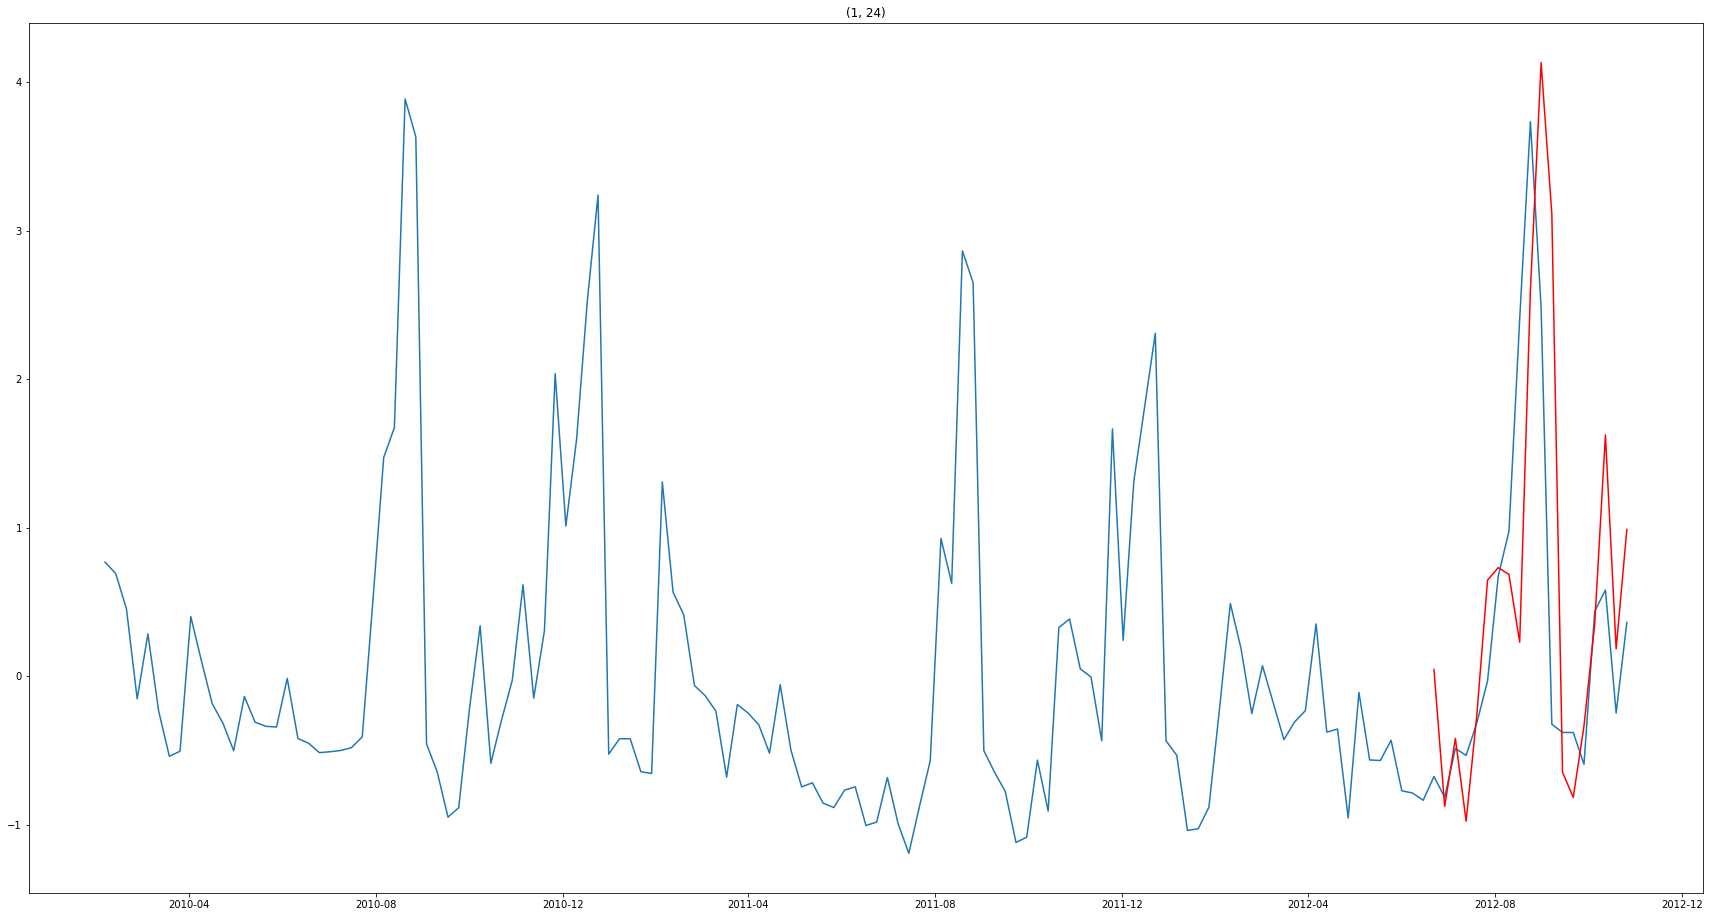

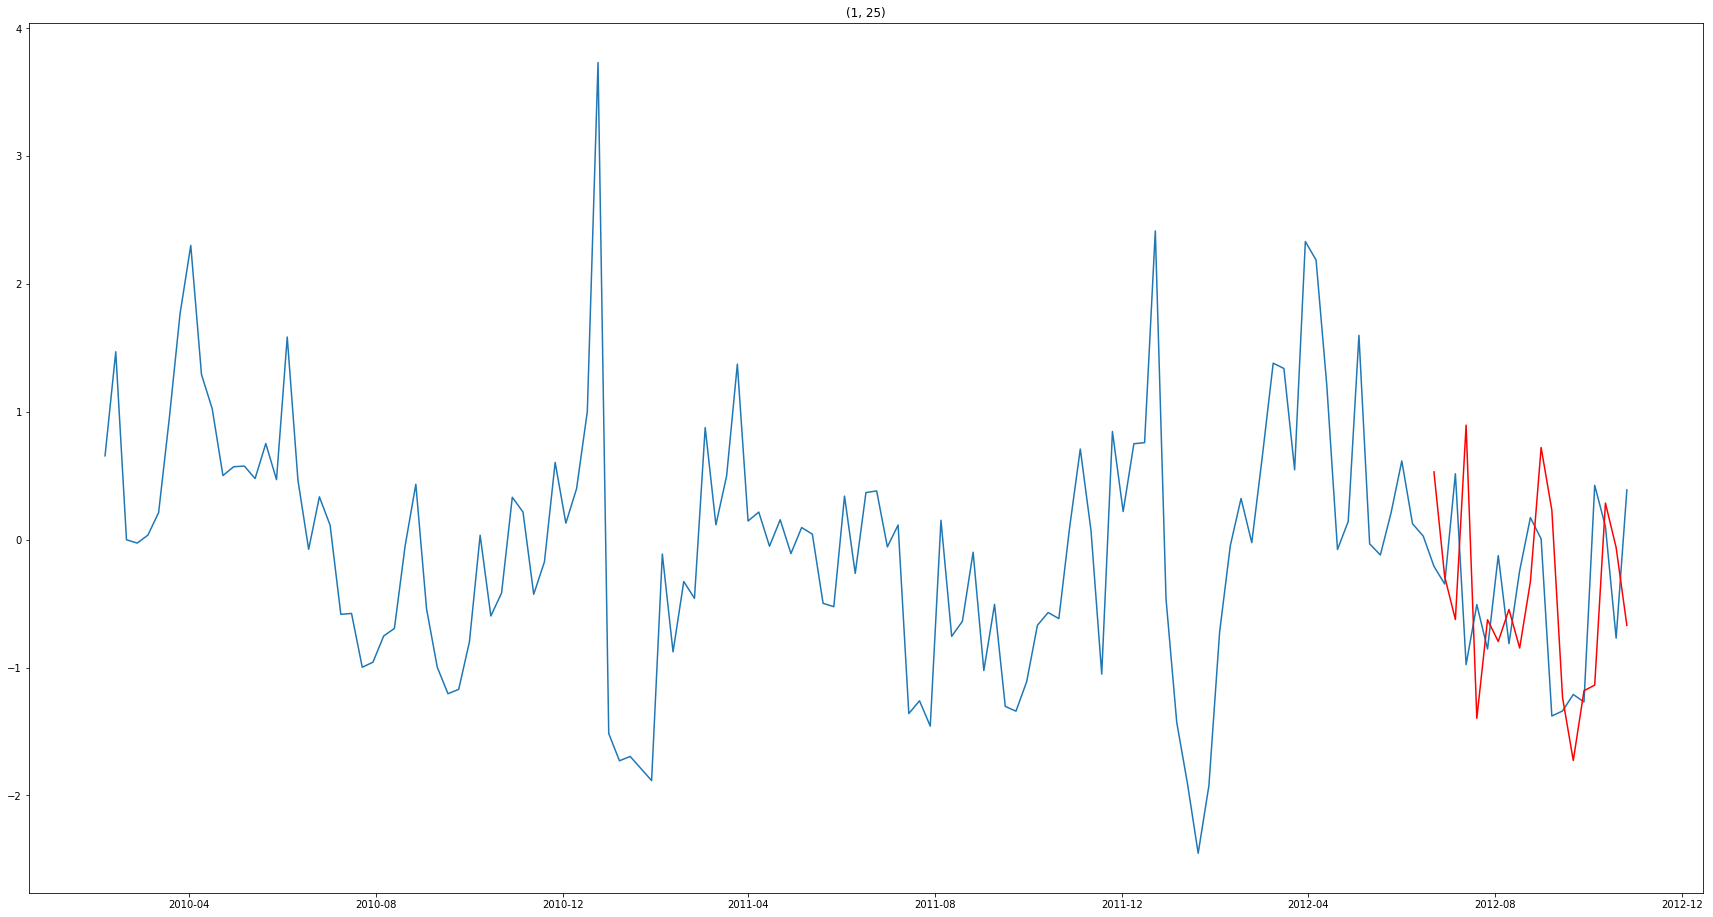

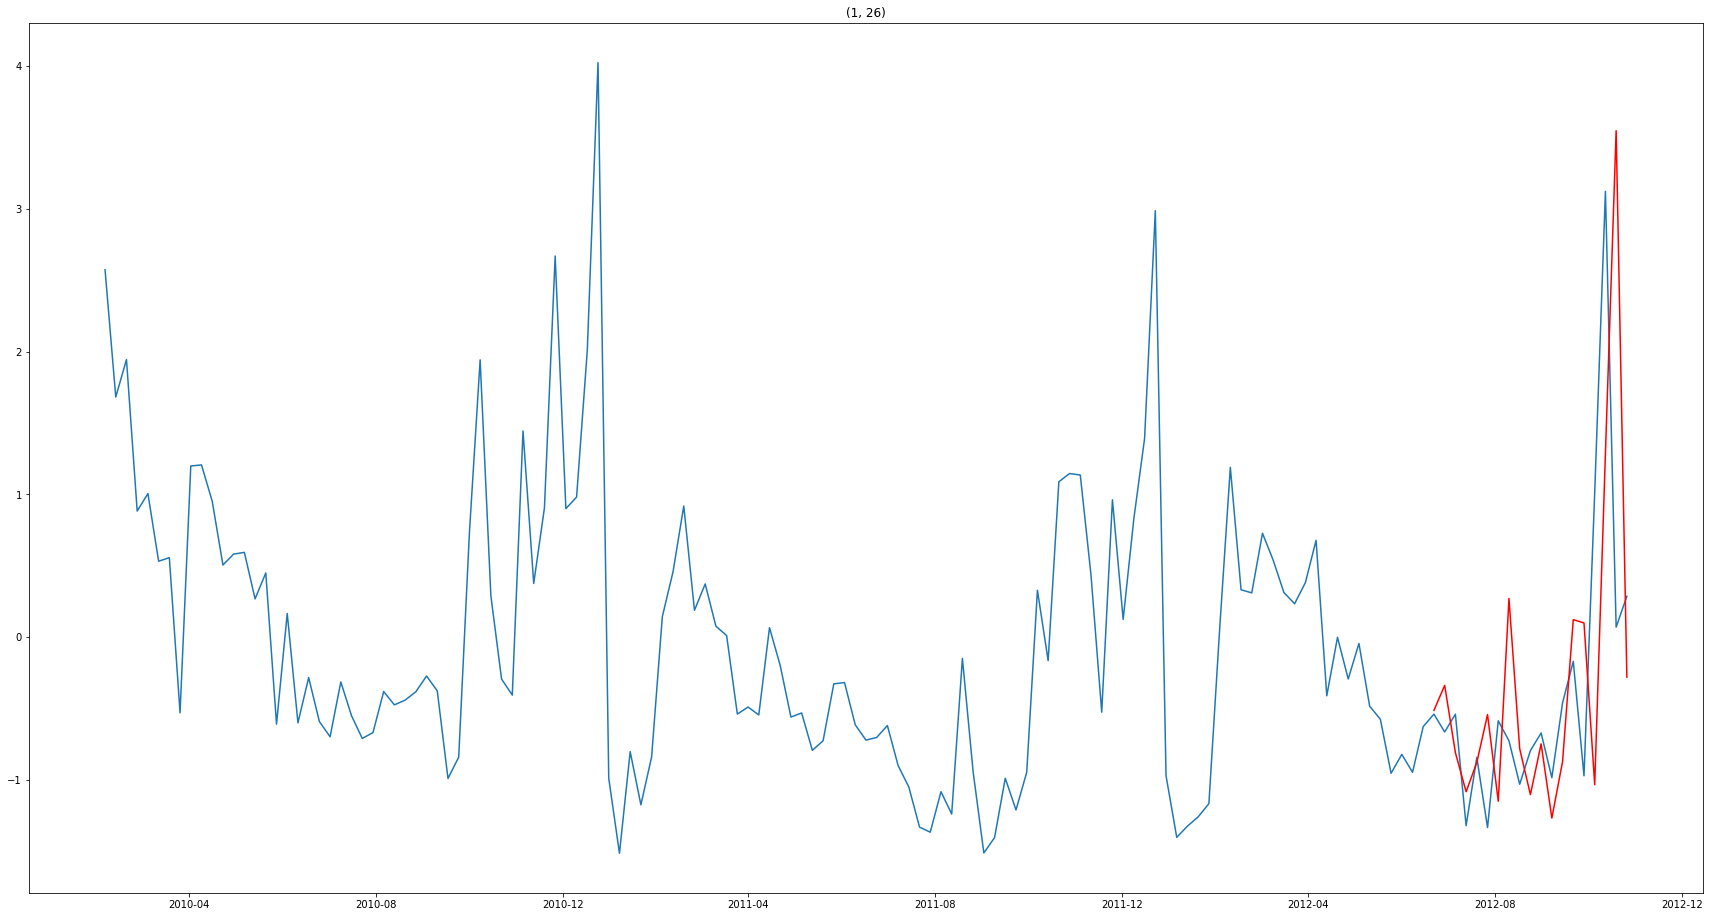

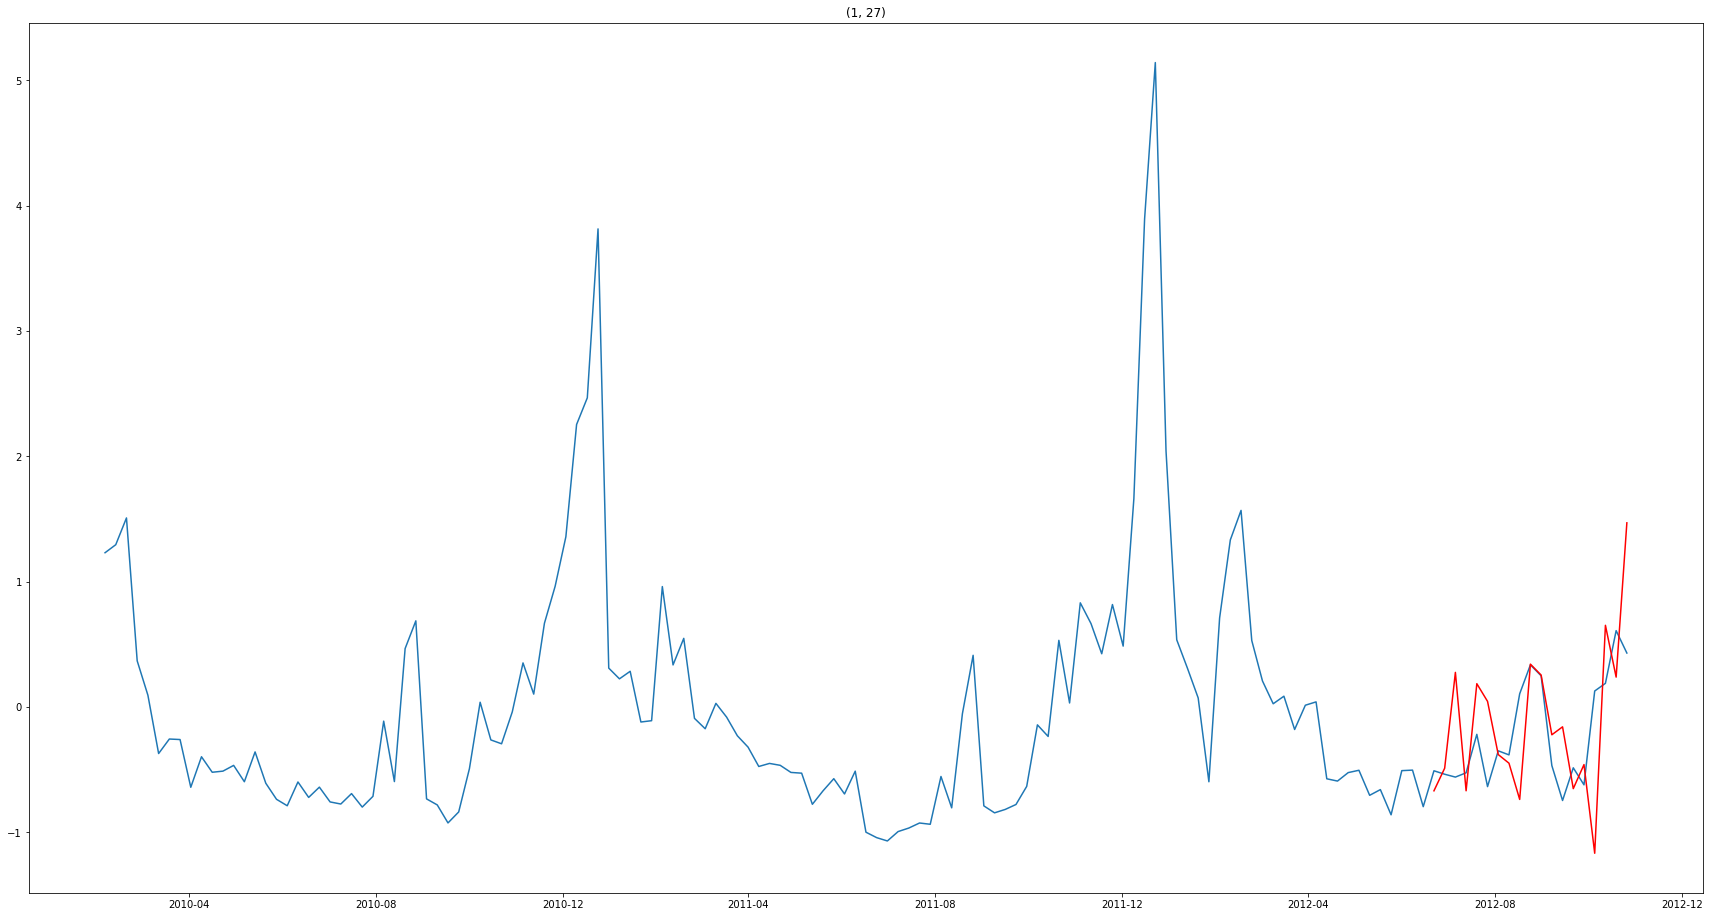

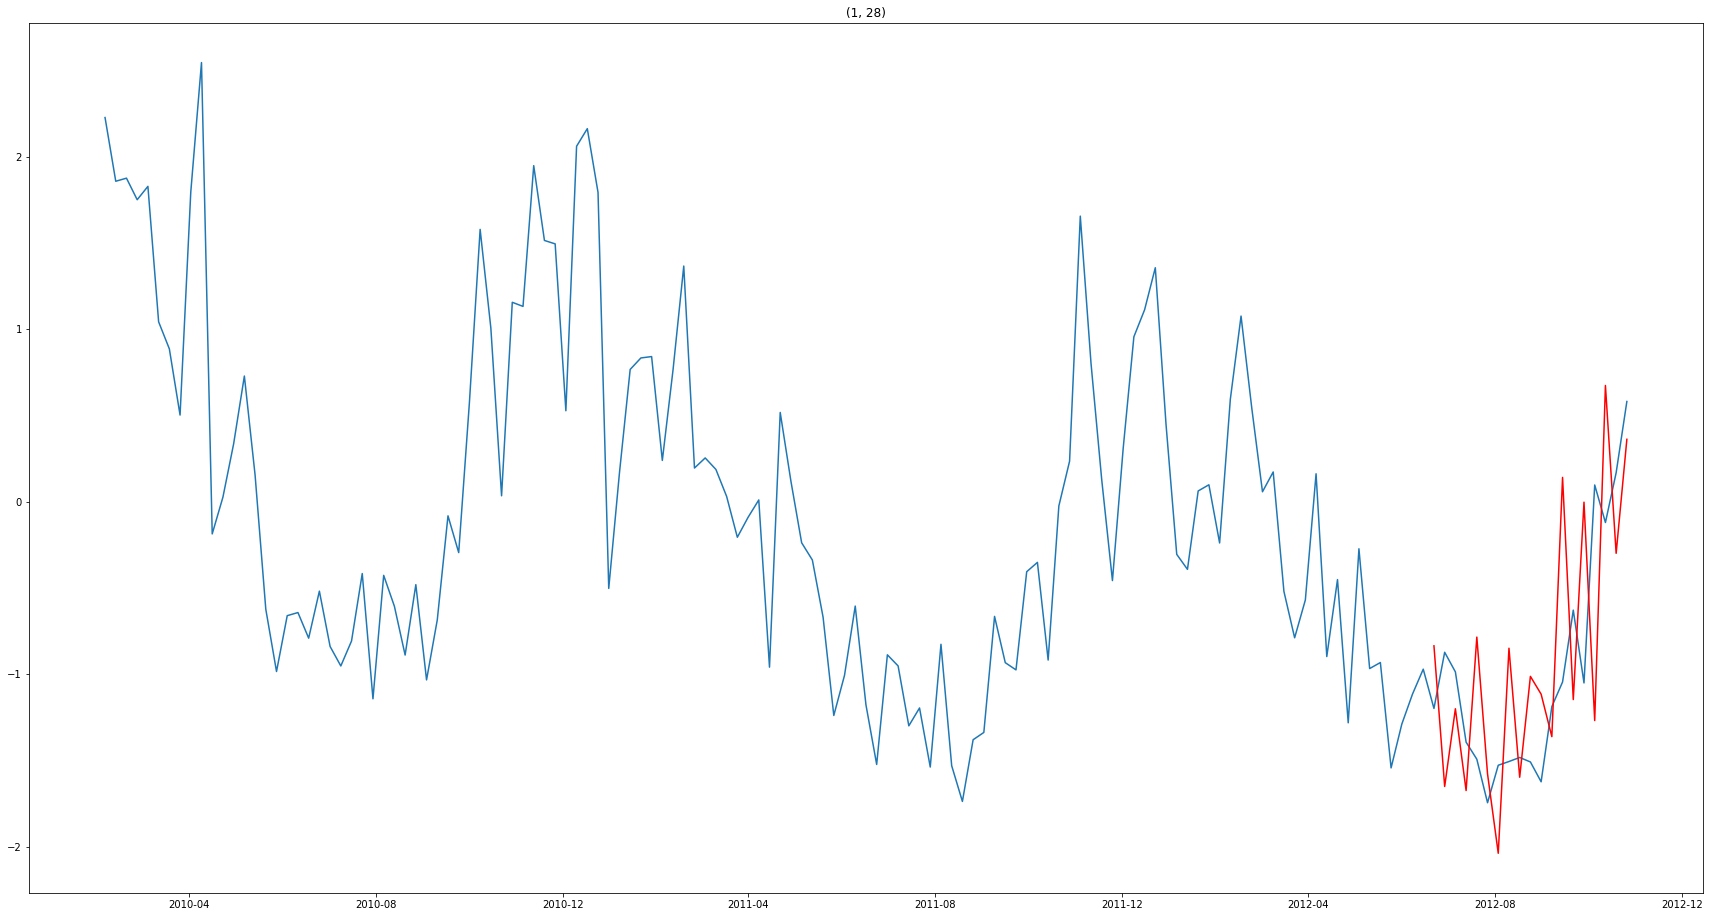

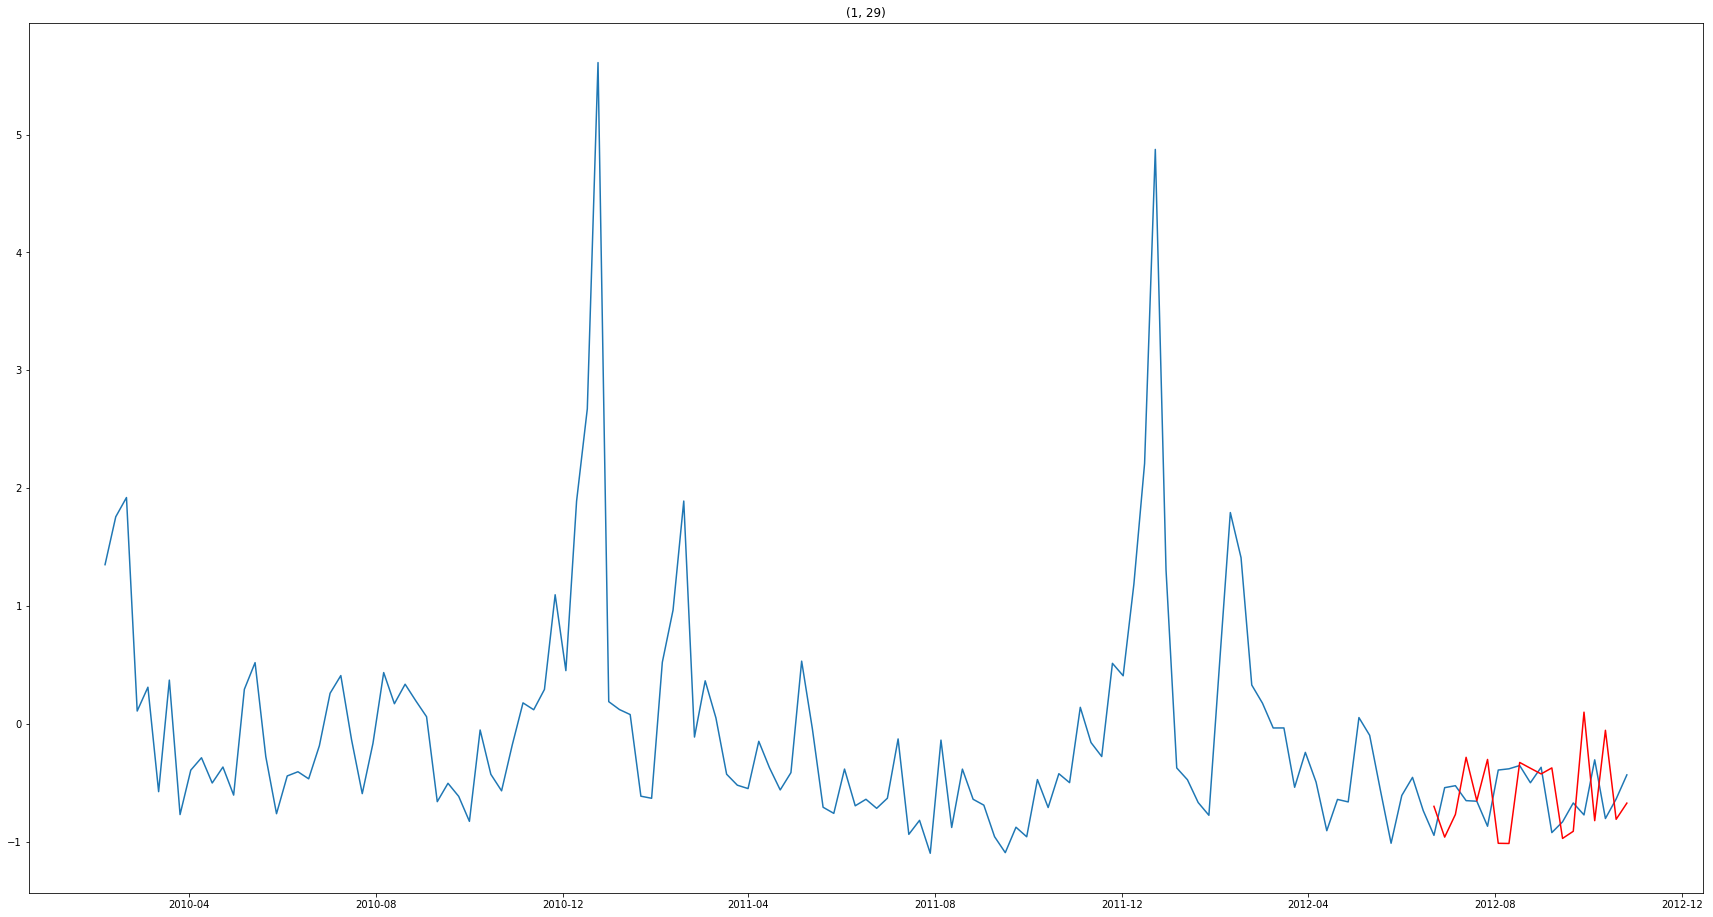

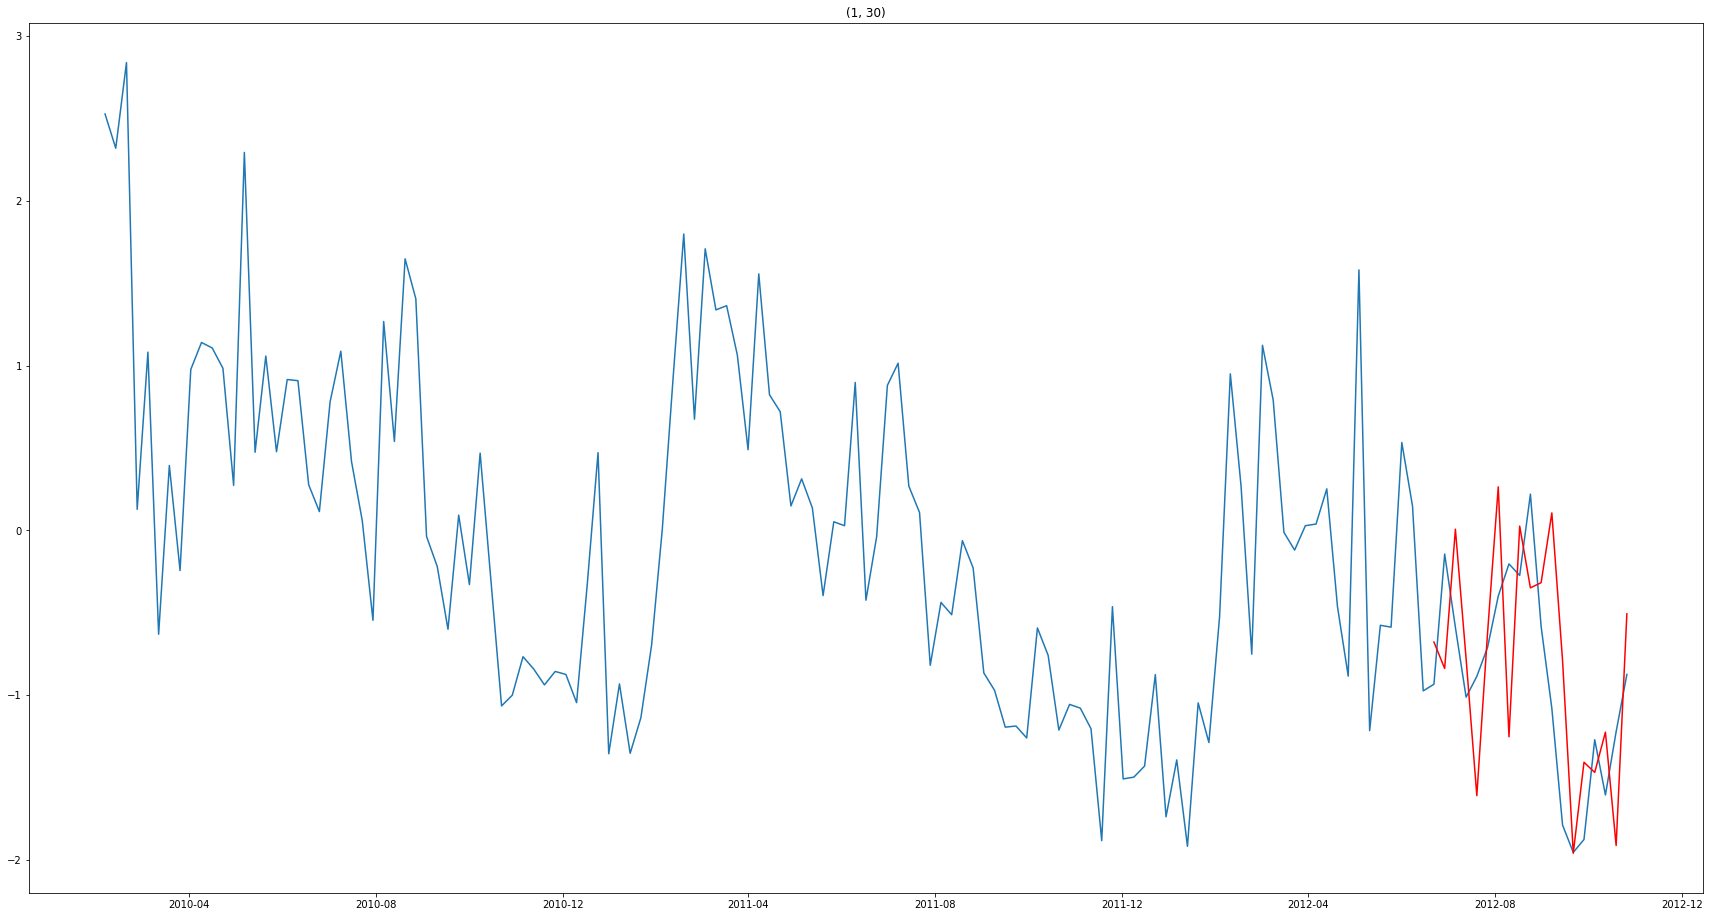

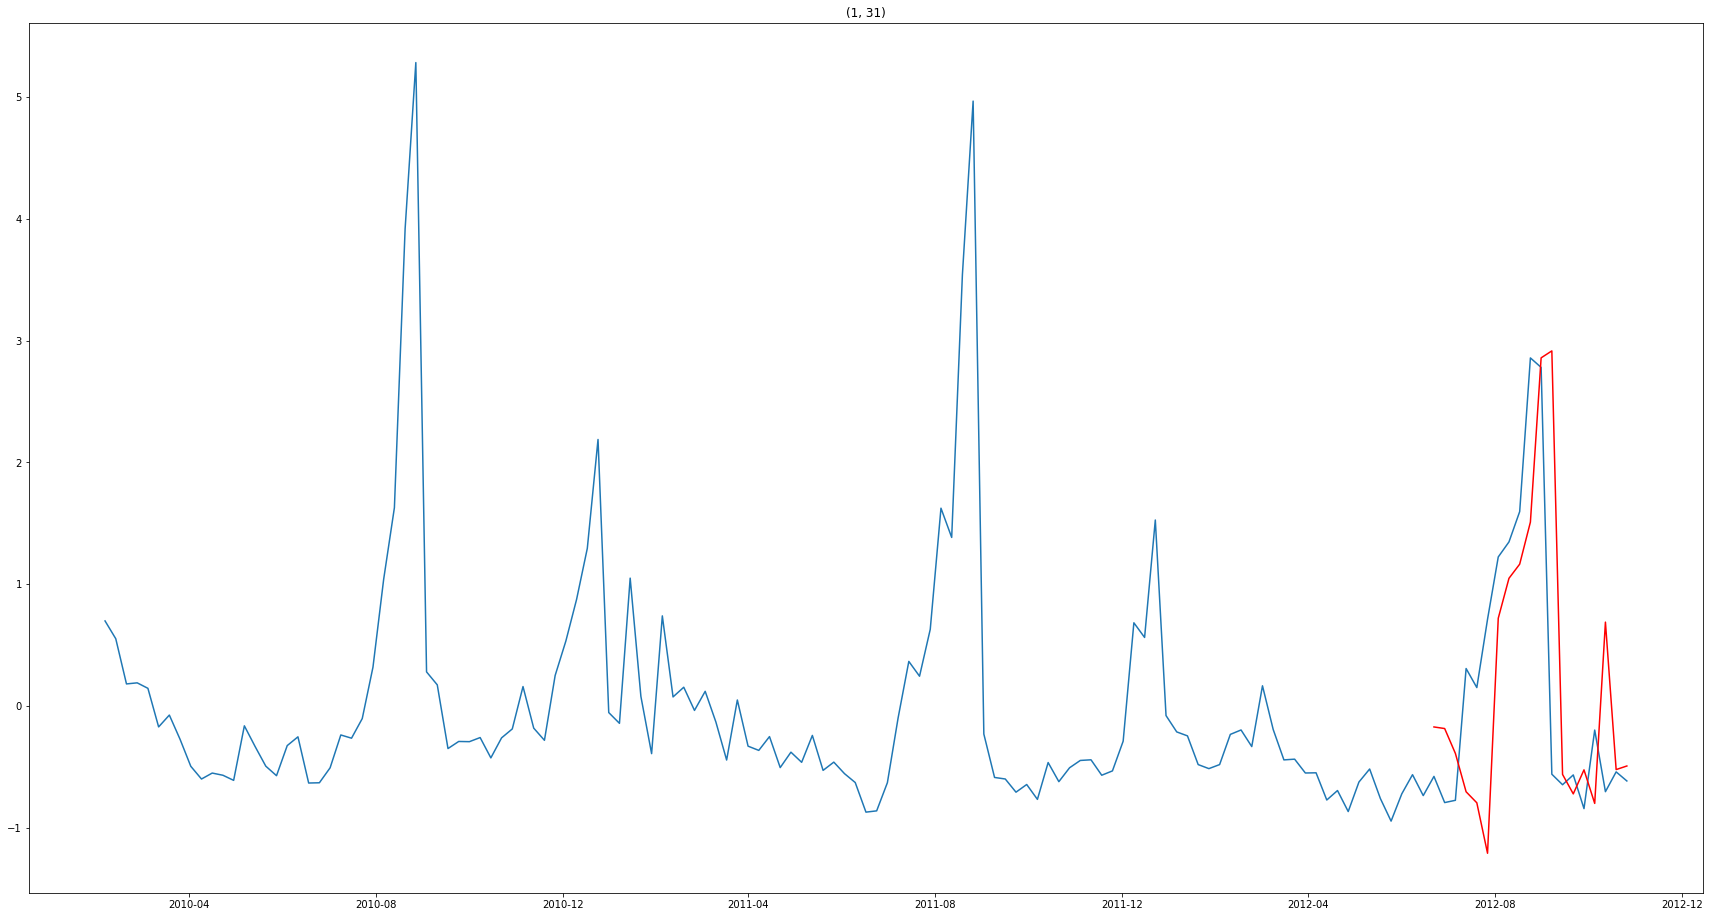

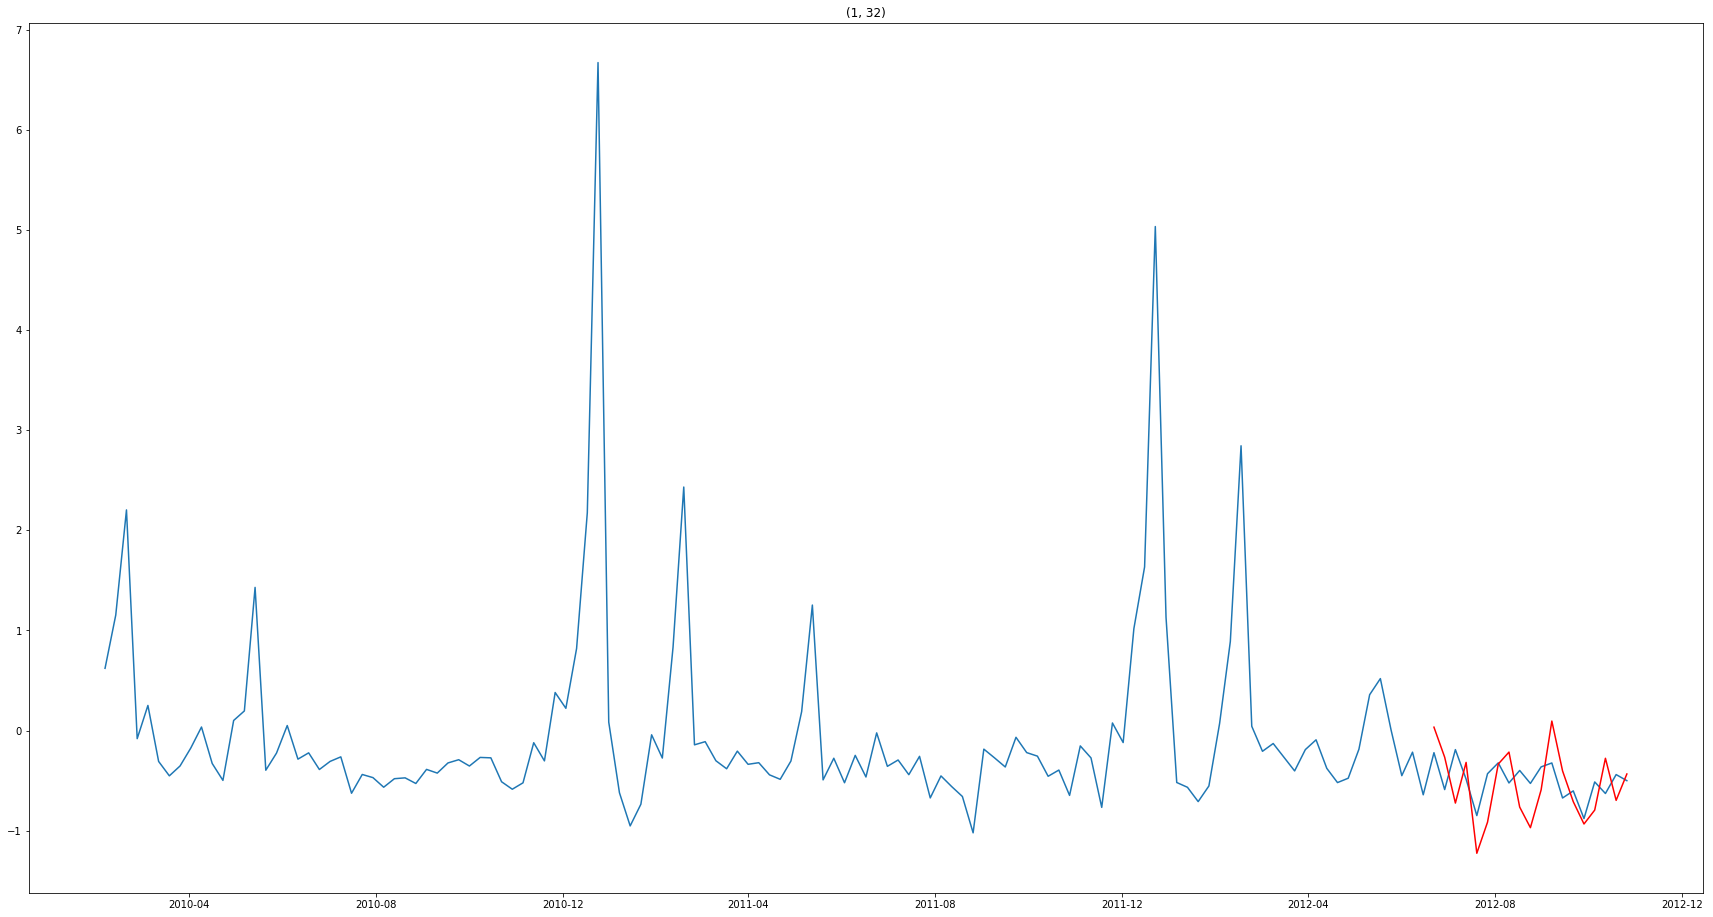

In [21]:
importlib.reload(knntsp)

cr_errors = 0
for result in cluster_real:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    cr_errors += mean_error[0]

cp_errors = 0
for result in cluster_predicted:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    cp_errors += mean_error[0]

sr_errors = 0
for result in simple_real:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    sr_errors += mean_error[0]

sp_errors = 0
for result in simple_predicted:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    sp_errors += mean_error[0]
    
print('Cluster real: ', cr_errors/len(cluster_real))
print('Cluster predicted: ', cp_errors/len(cluster_real))
print('Simple real: ', sr_errors/len(cluster_real))
print('Simple predicted: ', sp_errors/len(cluster_real))
for result in results_cluster_knn_real[:30]:
    current_X, current_Y, mean_error, w, k, cluster_label = result
    plt.figure(figsize=(30,16,))
    plt.title(current_X.columns[0])
    
    # Plot sem o valor real
    # plt.plot(X[:len(X) - len(predicted)])
    
    # Plot com o valor real
    plt.plot(current_X)
    
    plt.plot(pd.DataFrame(current_Y, index=current_X.index[len(current_X)-len(current_Y) +1: len(current_X)]), color='red')
    plt.show()

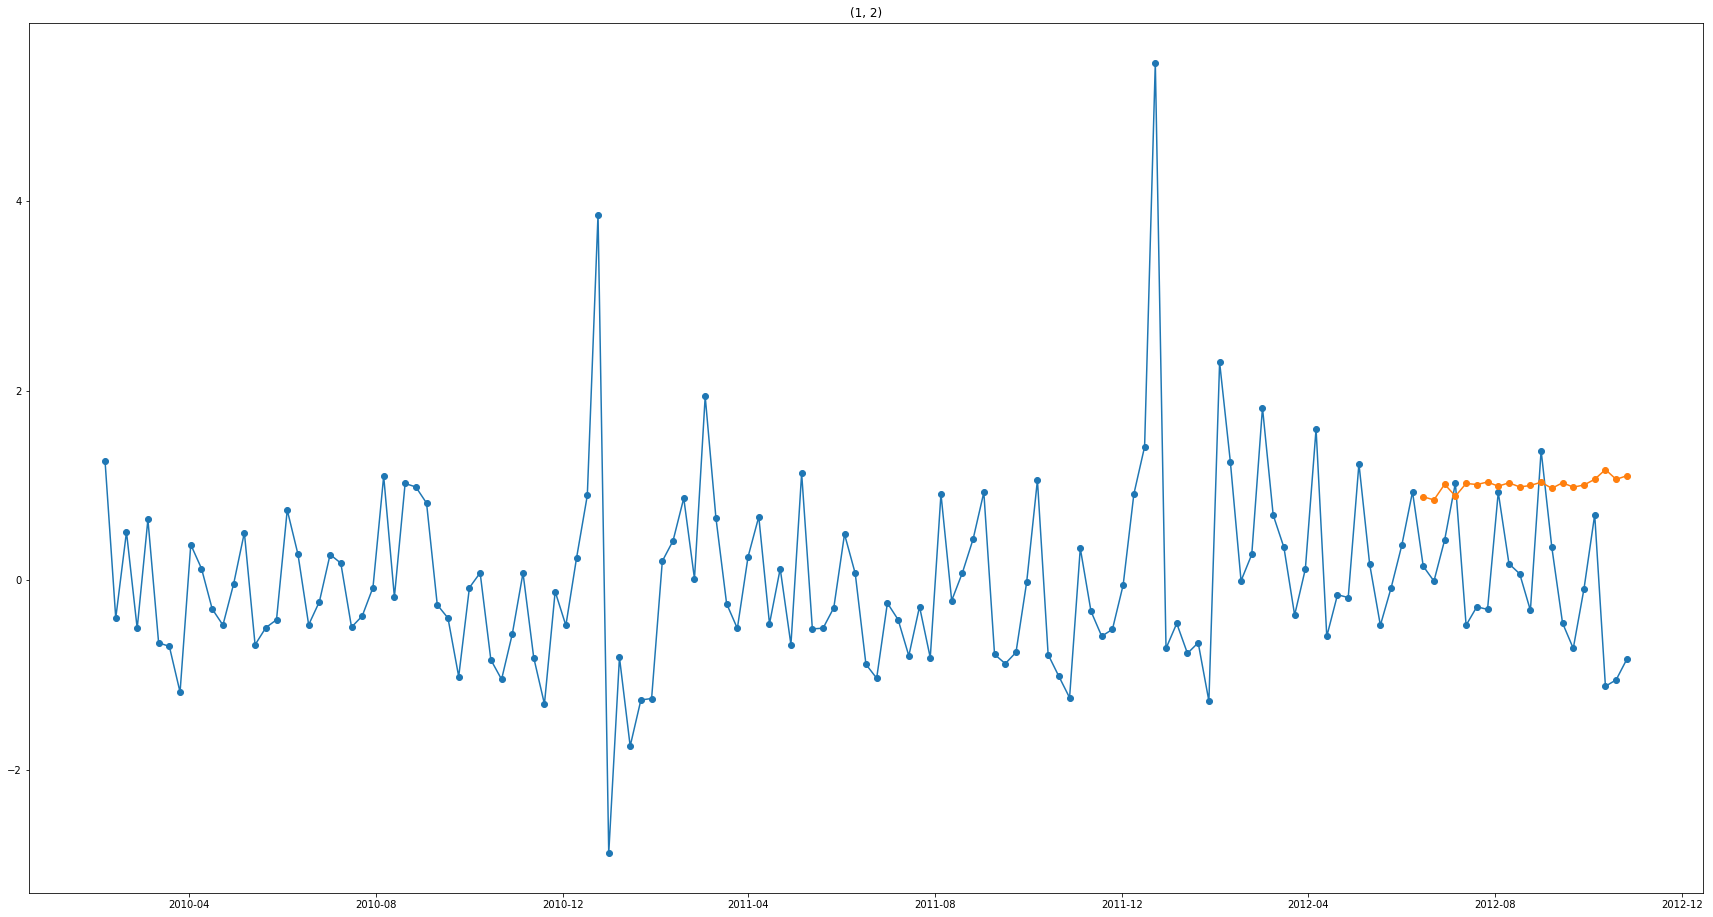

In [32]:
importlib.reload(knntsp)

# current_X, current_Y, mean_error, w, k, cluster_label = knntsp.predict_with_knn(timeSeries, timeSeries.columns.values[0], 27, 4, TRAIN_SIZE, False, False)
current_X, current_Y, mean_error, w, k, cluster_label = knntsp.predict_with_cluster_knn(timeSeries, timeSeries.columns.values[1], cluster_labels, 27,27, TRAIN_SIZE, False, False)
plt.figure(figsize=(30,16,))
plt.title(current_X.columns[0])

# Plot sem o valor real
# plt.plot(X[:len(X) - len(predicted)])

# Plot com o valor real
plt.plot(current_X, marker='o')
# plt.plot(pd.DataFrame(current_Y, index=current_X.index[len(current_X)-len(current_Y) +1: len(current_X)]), color='red')
plt.plot(current_Y, marker='o')
plt.show()